In [1]:
# Compute the multi-model-mean (mmm) and the multi-model-standard-deviation (mmstd) for mrsos, the upper 10 cm soil moisture content.
# We consider all model runs (and ensemble members) available in the historical simulations in the period 1979-2014.
# In the statistics, all the ensemble members have the same weight (i.e. we do not compute the mean for each model and then average among models).
# We also compute the bias of each model (here we average over all ensemble members available) with respect to the MMM.
# We consider different seasons separately.

# In similar notebooks we will compute the same variables also for
# - 2m air temperature
# - 2m specific humidity
# - z500

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import cftime
from scipy.interpolate import griddata
import matplotlib as mpl

In [2]:
path2era5 = '/bdd/ERA5/NETCDF/GLOBAL_025/1xmonthly/AN_SF/' # Soil Moisture is not already downloaded, but here the t2m, sstk and msl monthly fields are available.
path2cmip6 = '/bdd/CMIP6/CMIP/'

In [3]:
# Read a single ERA5 file to get the coordinates.
ds_era5 = xr.open_dataset(path2era5+'2020/t2m.2020.asme5.GLOBAL_025.nc')
lon = ds_era5.longitude.values
lat = ds_era5.latitude.values

In [4]:
# Check the models members which have mrsos data.

overall_member_counter = 0

list_of_folders = os.listdir(path2cmip6)
for folder in list_of_folders:
    list_of_models = os.listdir(path2cmip6 + folder)
    for model in list_of_models: 
        list_of_runs = os.listdir(path2cmip6 + folder + '/' + model) # 'historical', 'amip', 'piControl', 'abrupt-4xCO2', etc.
        if 'historical' in list_of_runs: #  Print the name of the models which have the historical run.
            print('# ',model)
            list_of_members_etal = os.listdir(path2cmip6 + folder + '/' + model +'/historical/')
            # Select only the ensemble members and skip the '.paths.txt' entries.
            list_of_members = [idx for idx in list_of_members_etal if idx[0].lower() == 'r'.lower()]
            #print(list_of_members)
            print('Ensemble members available = ' + str(len(list_of_members)))
# ?         Any reason to exclude any model?
# ?         What is the meaning of the names of the ensemble members?
            member_counter = 0
            for member in list_of_members: # Print the ensemble members that have info on the mrsos.
                if os.path.exists(path2cmip6 + folder + '/' + model +'/historical/' + member + '/Lmon/mrsos/'):
                    print('   # ', member)
                    member_counter += 1
            print('Ensemble members that have mrsos = ' + str(member_counter))
            overall_member_counter += member_counter
# ?         If we average all the members together, the models with a high number of members have a higher weight in the mmm.
#           Do we need to average the members of a given model first, and then compute the mmm?
    print('----------')
    
print(str(overall_member_counter) +' members have mrsos among their Lmon variables.')    

#  IPSL-CM6A-LR
Ensemble members available = 33
   #  r30i1p1f1
   #  r8i1p1f1
   #  r32i1p1f1
   #  r2i1p1f1
   #  r14i1p1f1
   #  r20i1p1f1
   #  r26i1p1f1
   #  r16i1p1f1
   #  r18i1p1f1
   #  r31i1p1f1
   #  r25i1p1f1
   #  r13i1p1f1
   #  r27i1p1f1
   #  r28i1p1f1
   #  r17i1p1f1
   #  r5i1p1f1
   #  r29i1p1f1
   #  r10i1p1f1
   #  r23i1p1f1
   #  r11i1p1f1
   #  r3i1p1f1
   #  r7i1p1f1
   #  r9i1p1f1
   #  r12i1p1f1
   #  r24i1p1f1
   #  r6i1p1f1
   #  r19i1p1f1
   #  r21i1p1f1
   #  r22i1p1f1
   #  r33i1p1f1
   #  r4i1p1f1
   #  r15i1p1f1
   #  r1i1p1f1
Ensemble members that have mrsos = 33
#  IPSL-CM5A2-INCA
Ensemble members available = 1
   #  r1i1p1f1
Ensemble members that have mrsos = 1
#  IPSL-CM6A-LR-INCA
Ensemble members available = 1
   #  r1i1p1f1
Ensemble members that have mrsos = 1
----------
#  KIOST-ESM
Ensemble members available = 1
Ensemble members that have mrsos = 0
----------
#  CIESM
Ensemble members available = 3
Ensemble members that have mrsos = 0
---------

In [21]:
# Check the type of time encoding for each model that contains mrsos. We can let the code distinguish.

overall_member_counter = 0

list_of_folders = os.listdir(path2cmip6)
for folder in list_of_folders:
    list_of_models = os.listdir(path2cmip6 + folder)
    for model in list_of_models: 
        list_of_runs = os.listdir(path2cmip6 + folder + '/' + model) # 'historical', 'amip', 'piControl', 'abrupt-4xCO2', etc.
        if 'historical' in list_of_runs: #  Print the name of the models which have the historical run.
            print('# ',model)
            path2members = path2cmip6 + folder + '/' + model +'/historical/'
            list_of_members_etal = os.listdir(path2members)
            # Select only the ensemble members and skip the '.paths.txt' entries.
            list_of_members = [idx for idx in list_of_members_etal if idx[0].lower() == 'r'.lower()]
            member_counter = 0
            for member in list_of_members: # Print the ensemble members that have info on the mrsos.
                if os.path.exists(path2members + member + '/Lmon/mrsos/gr/latest/'):
                    path2files = path2members + member + '/Lmon/mrsos/gr/latest/'
                    member_counter += 1
                elif os.path.exists(path2members + member + '/Lmon/mrsos/gr1/latest/'):
                    path2files = path2members + member + '/Lmon/mrsos/gr1/latest/'
                    member_counter += 1
                elif os.path.exists(path2members + member + '/Lmon/mrsos/gn/latest/'):
                    path2files = path2members + member + '/Lmon/mrsos/gn/latest/'
                    member_counter += 1
                else:
                    path2files = ''
                    
                if path2files: # If some data are available the path2file is not empty
                    list_of_files = sorted(os.listdir(path2files))
                    if list_of_files:
                        filename = list_of_files[0] # Check only for the first file for each member.
                        da = xr.open_dataset(path2files + filename)
                        if da.time.dtype=='datetime64[ns]':
                            print('Time is datetime64')
                        else:
                            print('Time is cftime with calendar: '+da.time.values[0].calendar) # We need to distinuguish the type of cftime
                    
            overall_member_counter += member_counter
    print('----------')
    
print(str(overall_member_counter) +' members have mrsos among their Lmon variables.')

#  IPSL-CM6A-LR
Time is datetime64
Time is datetime64
Time is datetime64
Time is datetime64
Time is datetime64
Time is datetime64
Time is datetime64
Time is datetime64
Time is datetime64
Time is datetime64
Time is datetime64
Time is datetime64
Time is datetime64
Time is datetime64
Time is datetime64
Time is datetime64
Time is datetime64
Time is datetime64
Time is datetime64
Time is datetime64
Time is datetime64
Time is datetime64
Time is datetime64
Time is datetime64
Time is datetime64
Time is datetime64
Time is datetime64
Time is datetime64
Time is datetime64
Time is datetime64
Time is datetime64
Time is datetime64
Time is datetime64
#  IPSL-CM5A2-INCA
Time is cftime with calendar: noleap
#  IPSL-CM6A-LR-INCA
Time is datetime64
----------
#  KIOST-ESM
----------
#  CIESM
----------
#  CNRM-CM6-1-HR
Time is datetime64
#  CNRM-CM6-1
Time is datetime64
Time is datetime64
Time is datetime64
Time is datetime64
Time is datetime64
Time is datetime64
Time is datetime64
Time is datetime64
Time

/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Time is cftime with calendar: noleap
Time is cftime with calendar: noleap
Time is cftime with calendar: noleap
#  CESM2-WACCM-FV2
Time is cftime with calendar: noleap
Time is cftime with calendar: noleap
Time is cftime with calendar: noleap
#  CESM2-FV2
Time is cftime with calendar: noleap
Time is cftime with calendar: noleap
Time is cftime with calendar: noleap
#  CESM2
Time is cftime with calendar: noleap
Time is cftime with calendar: noleap
Time is cftime with calendar: noleap
Time is cftime with calendar: noleap
Time is cftime with calendar: noleap
Time is cftime with calendar: noleap
Time is cftime with calendar: noleap
Time is cftime with calendar: noleap
Time is cftime with calendar: noleap
Time is cftime with calendar: noleap
Time is cftime with calendar: noleap
----------
#  FGOALS-f3-L
Time is cftime with calendar: noleap
Time is cftime with calendar: noleap
Time is cftime with calendar: noleap
#  CAS-ESM2-0
Time is cftime with calendar: noleap
Time is cftime with calendar: n

In [87]:
# Compute the annual mmm for mrsos in the time window 197901-201412 (as in Qiao et al., 2023).

###### SAVE THE LIST OF FOLDERS WITH VALID DATA, TO BE USED FOR THE ATMOSPHERIC VARIABLES OF INTEREST!!!

first_field = 1
counter = 0
overall_member_counter = 0

folder_with_valid_mrsos_data = []

list_of_folders = os.listdir(path2cmip6)
for folder in list_of_folders:
    list_of_models = os.listdir(path2cmip6 + folder)
    for model in list_of_models: 
        list_of_runs = os.listdir(path2cmip6 + folder + '/' + model) # 'historical', 'amip', 'piControl', 'abrupt-4xCO2', etc.
        if 'historical' in list_of_runs: #  Print the name of the models which have the historical run.
            print('# ',model)
            path2members = path2cmip6 + folder + '/' + model +'/historical/'
            list_of_members_etal = os.listdir(path2members)
            # Select only the ensemble members and skip the '.paths.txt' entries.
            list_of_members = [idx for idx in list_of_members_etal if idx[0].lower() == 'r'.lower()]
            member_counter = 0
            for member in list_of_members: # Print the ensemble members that have info on the mrsos.
                if os.path.exists(path2members + member + '/Lmon/mrsos/gr/latest/'):
                    path2files = path2members + member + '/Lmon/mrsos/gr/latest/'
                elif os.path.exists(path2members + member + '/Lmon/mrsos/gr1/latest/'):
                    path2files = path2members + member + '/Lmon/mrsos/gr1/latest/'
                elif os.path.exists(path2members + member + '/Lmon/mrsos/gn/latest/'):
                    path2files = path2members + member + '/Lmon/mrsos/gn/latest/'
                else:
                    path2files = ''
                    
                if path2files: # If some data are available the path2file is not empty.
                    # Open and concatenate all the files whose final date is after 197901.
                    list_of_files = sorted(os.listdir(path2files))
                    # print('list_of_files =', list_of_files) # There is a member in EC-Earth that has no file but it read anyhow...
                    if list_of_files: # Check whether there are output files to be read.
                        first_file = 1
                        for ll in range(len(list_of_files)):
                            filename = list_of_files[ll]
                            final_date = filename[-9:-3]
                            if int(final_date)>197901: # Here the instant_start is re-written in the form of YYYYMM.
                                da = xr.open_dataset(path2files + filename)
                                if first_file:
                                    db = da
                                    first_file = 0
                                else:
                                    db = xr.concat([db,da],dim='time')

                        # Select the time window according to the type of time axis.
                        if db.time.dtype=='datetime64[ns]':
                            instant_start = np.datetime64('1979-01-01')
                            instant_end = np.datetime64('2014-12-31')
                        else:
                            if db.time.values[0].calendar=='noleap':
                                instant_start = cftime.DatetimeNoLeap(1979,1,1,0,0,0,0,has_year_zero=True)
                                instant_end = cftime.DatetimeNoLeap(2014,12,31,0,0,0,0,has_year_zero=True)
                            elif db.time.values[0].calendar=='360_day':
                                instant_start = cftime.Datetime360Day(1979,1,1,0,0,0,0,has_year_zero=False)
                                instant_end = cftime.Datetime360Day(2014,12,17,0,0,0,0,has_year_zero=False)     

                        # Compute the temporal mean in the time frame of interest and interpolate it on the ERA5 grid.        
                        d_mean = db.mrsos.sel(time=slice(instant_start,instant_end)).mean(dim='time')
                        if first_field:
                            d_mean_i = d_mean.interp(lon=ds_era5.longitude,lat=ds_era5.latitude)
                            first_field=0
                        else:
                            d_mean_i += d_mean.interp(lon=ds_era5.longitude,lat=ds_era5.latitude)
                        counter += 1
                        member_counter += 1
                        folder_with_valid_mrsos_data.append(path2members + member)

                print('Ensemble member '+str(member_counter)+' out of '+str(len(list_of_members)))

            overall_member_counter += member_counter
                                        
    print('----------')
    
print(str(overall_member_counter) +' members have mrsos among their Lmon variables.')   
print('Number of members actually used: '+ str(counter))

#  IPSL-CM6A-LR
Ensemble member 1 out of 33
Ensemble member 2 out of 33
Ensemble member 3 out of 33
Ensemble member 4 out of 33
Ensemble member 5 out of 33
Ensemble member 6 out of 33
Ensemble member 7 out of 33
Ensemble member 8 out of 33
Ensemble member 9 out of 33
Ensemble member 10 out of 33
Ensemble member 11 out of 33
Ensemble member 12 out of 33
Ensemble member 13 out of 33
Ensemble member 14 out of 33
Ensemble member 15 out of 33
Ensemble member 16 out of 33
Ensemble member 17 out of 33
Ensemble member 18 out of 33
Ensemble member 19 out of 33
Ensemble member 20 out of 33
Ensemble member 21 out of 33
Ensemble member 22 out of 33
Ensemble member 23 out of 33
Ensemble member 24 out of 33
Ensemble member 25 out of 33
Ensemble member 26 out of 33
Ensemble member 27 out of 33
Ensemble member 28 out of 33
Ensemble member 29 out of 33
Ensemble member 30 out of 33
Ensemble member 31 out of 33
Ensemble member 32 out of 33
Ensemble member 33 out of 33
#  IPSL-CM5A2-INCA
Ensemble member 1

/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 1 out of 3


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 2 out of 3


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 3 out of 3
#  CESM2-WACCM-FV2
Ensemble member 1 out of 3


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 2 out of 3


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 3 out of 3
#  CESM2-FV2


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 1 out of 4
Ensemble member 2 out of 4
Ensemble member 2 out of 4


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 3 out of 4
#  CESM2


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 1 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 2 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 3 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 4 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 5 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 6 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 7 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 8 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 9 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 10 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 11 out of 11
----------
#  FGOALS-f3-L
Ensemble member 1 out of 3
Ensemble member 2 out of 3
Ensemble member 3 out of 3
#  CAS-ESM2-0
Ensemble member 1 out of 4
Ensemble member 2 out of 4
Ensemble member 3 out of 4
Ensemble member 4 out of 4
#  FGOALS-g3
Ensemble member 1 out of 6
Ensemble member 2 out of 6
Ensemble member 3 out of 6
Ensemble member 4 out of 6
Ensemble member 5 out of 6
Ensemble member 6 out of 6
----------
#  SAM0-UNICON
Ensemble member 1 out of 1
----------
#  UKESM1-0-LL
Ensemble member 1 out of 16
Ensemble member 2 out of 16
Ensemble member 3 out of 16
Ensemble member 4 out of 16
Ensemble member 5 out of 16
Ensemble member 6 out of 16
Ensemble member 7 out of 16
Ensemble member 8 out of 16
Ensemble member 9 out of 16
Ensemble member 10 out of 16
Ensemble member 11 out of 16
Ensemble member 12 out of 16
Ensemble member 13 out of 16
Ensemble member 14 out of 16
Ensemble member 15 out of 16
Ensemble member 16 out of 16
#  HadGEM3-GC31-LL
Ensemble membe

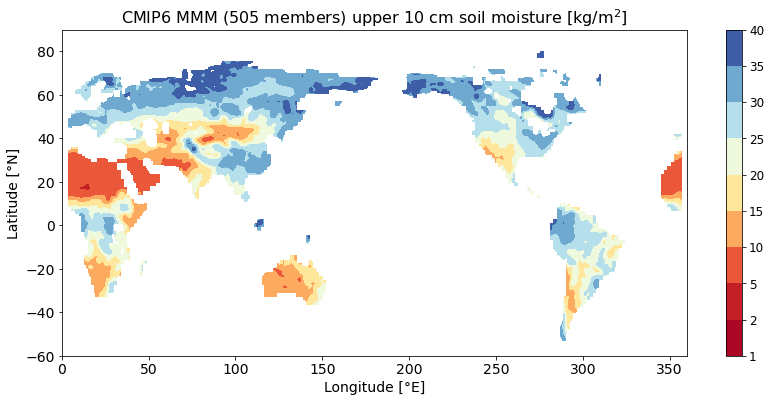

In [88]:
mean_mrsos = d_mean_i.values/counter

lon = d_mean_i.longitude.values
lat = d_mean_i.latitude.values

fig = plt.figure(figsize=(14,6))
pc = plt.contourf(lon,lat,mean_mrsos,levels=[1,2,5,10,15,20,25,30,35,40],cmap='RdYlBu')#,shading='nearest')
plt.xlabel('Longitude [°E]',fontsize=14)
plt.ylabel('Latitude [°N]',fontsize=14)
plt.ylim([-60,90])
plt.tick_params(axis='both',labelsize=14)

cb = plt.colorbar(pc)
cb.ax.tick_params(labelsize=12)

plt.title('CMIP6 MMM ('+str(counter)+' members) upper 10 cm soil moisture [kg/m$^2$]',fontsize=16)
plt.savefig('mmm_mrsos_1979-2014_allmodels.png',bbox_inches='tight') # It is very similar to the one in Qiao et al. (2023).

In [8]:
# Compute the mmstd for mrsos in the time window 197901-201412.

first_field = 1
counter = 0
overall_member_counter = 0

list_of_folders = os.listdir(path2cmip6)
for folder in list_of_folders:
    list_of_models = os.listdir(path2cmip6 + folder)
    for model in list_of_models: 
        list_of_runs = os.listdir(path2cmip6 + folder + '/' + model) # 'historical', 'amip', 'piControl', 'abrupt-4xCO2', etc.
        if 'historical' in list_of_runs: #  Print the name of the models which have the historical run.
            print('# ',model)
            path2members = path2cmip6 + folder + '/' + model +'/historical/'
            list_of_members_etal = os.listdir(path2members)
            # Select only the ensemble members and skip the '.paths.txt' entries.
            list_of_members = [idx for idx in list_of_members_etal if idx[0].lower() == 'r'.lower()]
            print('Number of members available: '+str(len(list_of_members)))
            member_counter = 0
            for member in list_of_members: # Print the ensemble members that have info on the mrsos.
                if os.path.exists(path2members + member + '/Lmon/mrsos/gr/latest/'):
                    path2files = path2members + member + '/Lmon/mrsos/gr/latest/'
                elif os.path.exists(path2members + member + '/Lmon/mrsos/gr1/latest/'):
                    path2files = path2members + member + '/Lmon/mrsos/gr1/latest/'
                elif os.path.exists(path2members + member + '/Lmon/mrsos/gn/latest/'):
                    path2files = path2members + member + '/Lmon/mrsos/gn/latest/'
                else:
                    path2files = ''
                    
                if path2files: # If some data are available the path2file is not empty.
                    # Open and concatenate all the files whose final date is after 197901.
                    list_of_files = sorted(os.listdir(path2files))
                    # print('list_of_files =', list_of_files) # There is a member in EC-Earth that has no file but it read anyhow...
                    if list_of_files: # Check whether there are output files to be read.
                        first_file = 1
                        for ll in range(len(list_of_files)):
                            filename = list_of_files[ll]
                            final_date = filename[-9:-3]
                            if int(final_date)>197901: # Here the instant_start is re-written in the form of YYYYMM.
                                da = xr.open_dataset(path2files + filename)
                                if first_file:
                                    db = da
                                    first_file = 0
                                else:
                                    db = xr.concat([db,da],dim='time')

                        # Select the time window according to the type of time axis.
                        if db.time.dtype=='datetime64[ns]':
                            instant_start = np.datetime64('1979-01-01')
                            instant_end = np.datetime64('2014-12-31')
                        else:
                            if db.time.values[0].calendar=='noleap':
                                instant_start = cftime.DatetimeNoLeap(1979,1,1,0,0,0,0,has_year_zero=True)
                                instant_end = cftime.DatetimeNoLeap(2014,12,31,0,0,0,0,has_year_zero=True)
                            elif db.time.values[0].calendar=='360_day':
                                instant_start = cftime.Datetime360Day(1979,1,1,0,0,0,0,has_year_zero=False)
                                instant_end = cftime.Datetime360Day(2014,12,17,0,0,0,0,has_year_zero=False)     

# ? Should we first average all the ensemble members for each model and then compute the MM-statistics?

                        # Compute the temporal mean in the time frame of interest and interpolate it on the ERA5 grid.        
                        d_mean = db.mrsos.sel(time=slice(instant_start,instant_end)).mean(dim='time')
                        d_mean_i = d_mean.interp(lon=ds_era5.longitude,lat=ds_era5.latitude)
                        if first_field:
                            d_mean4std = (d_mean_i-mean_mrsos)**2
                            first_field=0
                        else:
                            d_mean4std += (d_mean_i-mean_mrsos)**2
                        print(member)
                        counter += 1
                        member_counter += 1 # This is set to zero for each model
            print('Number of ensemble members used: '+str(member_counter))
            overall_member_counter += member_counter
                                        
    print('----------')
    
print('Number of members actually used in total: '+ str(counter))

#  IPSL-CM6A-LR
Number of members available: 33
r30i1p1f1
r8i1p1f1
r32i1p1f1
r2i1p1f1
r14i1p1f1
r20i1p1f1
r26i1p1f1
r16i1p1f1
r18i1p1f1
r31i1p1f1
r25i1p1f1
r13i1p1f1
r27i1p1f1
r28i1p1f1
r17i1p1f1
r5i1p1f1
r29i1p1f1
r10i1p1f1
r23i1p1f1
r11i1p1f1
r3i1p1f1
r7i1p1f1
r9i1p1f1
r12i1p1f1
r24i1p1f1
r6i1p1f1
r19i1p1f1
r21i1p1f1
r22i1p1f1
r33i1p1f1
r4i1p1f1
r15i1p1f1
r1i1p1f1
Number of ensemble members used: 33
#  IPSL-CM5A2-INCA
Number of members available: 1
r1i1p1f1
Number of ensemble members used: 1
#  IPSL-CM6A-LR-INCA
Number of members available: 1
r1i1p1f1
Number of ensemble members used: 1
----------
#  KIOST-ESM
Number of members available: 1
Number of ensemble members used: 0
----------
#  CIESM
Number of members available: 3
Number of ensemble members used: 0
----------
#  CNRM-CM6-1-HR
Number of members available: 1
r1i1p1f2
Number of ensemble members used: 1
#  CNRM-CM6-1
Number of members available: 30
r3i1p1f2
r28i1p1f2
r29i1p1f2
r30i1p1f2
r27i1p1f2
r7i1p1f2
r23i1p1f2
r4i1p1f2
r10

/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r2i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r1i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r3i1p1f1
Number of ensemble members used: 3
#  CESM2-WACCM-FV2
Number of members available: 3
r2i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r1i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r3i1p1f1
Number of ensemble members used: 3
#  CESM2-FV2
Number of members available: 4


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r2i1p1f1
r1i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r3i1p1f1
Number of ensemble members used: 3
#  CESM2
Number of members available: 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r2i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r5i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r1i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r4i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r3i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r9i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r8i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r10i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r7i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r11i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r6i1p1f1
Number of ensemble members used: 11
----------
#  FGOALS-f3-L
Number of members available: 3
r2i1p1f1
r1i1p1f1
r3i1p1f1
Number of ensemble members used: 3
#  CAS-ESM2-0
Number of members available: 4
r2i1p1f1
r1i1p1f1
r4i1p1f1
r3i1p1f1
Number of ensemble members used: 4
#  FGOALS-g3
Number of members available: 6
r2i1p1f1
r5i1p1f1
r1i1p1f1
r4i1p1f1
r3i1p1f1
r6i1p1f1
Number of ensemble members used: 6
----------
#  SAM0-UNICON
Number of members available: 1
r1i1p1f1
Number of ensemble members used: 1
----------
#  UKESM1-0-LL
Number of members available: 16
r3i1p1f2
r5i1p1f3
r4i1p1f2
r10i1p1f2
r11i1p1f2
r8i1p1f2
r1i1p1f2
r7i1p1f3
r12i1p1f2
r19i1p1f2
r16i1p1f2
r9i1p1f2
r2i1p1f2
r17i1p1f2
r18i1p1f2
r6i1p1f3
Number of ensemble members used: 16
#  HadGEM3-GC31-LL
Number of members available: 55
Number of ensemble members used: 0
#  HadGEM3-GC31-MM
Number of members available: 4
Number of ensemble members used: 0
----------
#  AWI-CM-1-1-MR
Number of members available: 5
Number of e

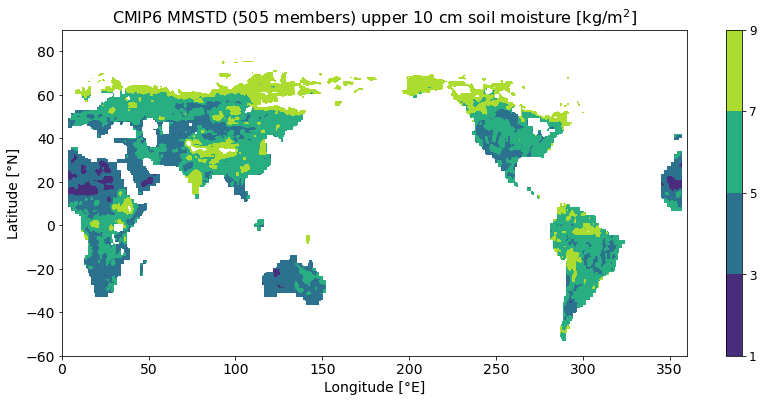

In [9]:
mmstd_mrsos = np.sqrt(d_mean4std.values/counter)

fig = plt.figure(figsize=(14,6))
pc = plt.contourf(lon,lat,mmstd_mrsos,levels=[1,3,5,7,9],cmap='viridis')#,shading='nearest')
plt.xlabel('Longitude [°E]',fontsize=14)
plt.ylabel('Latitude [°N]',fontsize=14)
plt.ylim([-60,90])
plt.tick_params(axis='both',labelsize=14)

cb = plt.colorbar(pc)
cb.ax.tick_params(labelsize=12)

plt.title('CMIP6 MMSTD ('+str(counter)+' members) upper 10 cm soil moisture [kg/m$^2$]',fontsize=16)
plt.savefig('mmstd_mrsos_1979-2014_allmodels.png',bbox_inches='tight')

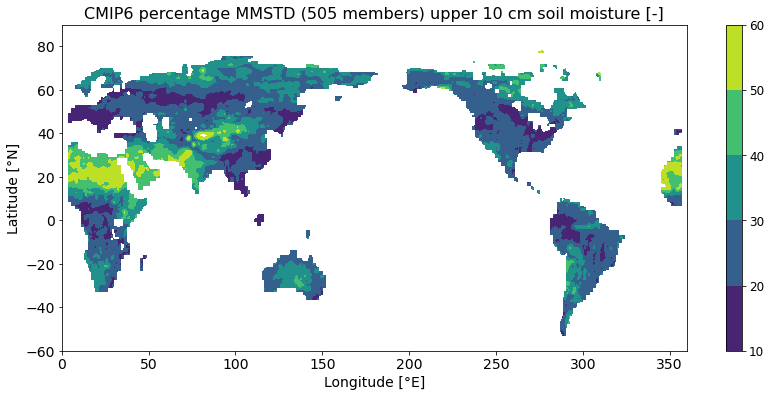

In [14]:
fig = plt.figure(figsize=(14,6))
pc = plt.contourf(lon,lat,100*mmstd_mrsos/mean_mrsos,levels=np.arange(10,70,10),cmap='viridis')#,shading='nearest')
plt.xlabel('Longitude [°E]',fontsize=14)
plt.ylabel('Latitude [°N]',fontsize=14)
plt.ylim([-60,90])
plt.tick_params(axis='both',labelsize=14)

cb = plt.colorbar(pc)
cb.ax.tick_params(labelsize=12)

plt.title('CMIP6 percentage MMSTD ('+str(counter)+' members) upper 10 cm soil moisture [-]',fontsize=16)
plt.savefig('mmstd_perc_mrsos_1979-2014_allmodels.png',bbox_inches='tight')

#  IPSL-CM6A-LR
Number of members available: 33
r30i1p1f1
r8i1p1f1
r32i1p1f1
r2i1p1f1
r14i1p1f1
r20i1p1f1
r26i1p1f1
r16i1p1f1
r18i1p1f1
r31i1p1f1
r25i1p1f1
r13i1p1f1
r27i1p1f1
r28i1p1f1
r17i1p1f1
r5i1p1f1
r29i1p1f1
r10i1p1f1
r23i1p1f1
r11i1p1f1
r3i1p1f1
r7i1p1f1
r9i1p1f1
r12i1p1f1
r24i1p1f1
r6i1p1f1
r19i1p1f1
r21i1p1f1
r22i1p1f1
r33i1p1f1
r4i1p1f1
r15i1p1f1
r1i1p1f1
#  IPSL-CM5A2-INCA
Number of members available: 1
r1i1p1f1
#  IPSL-CM6A-LR-INCA
Number of members available: 1
r1i1p1f1
----------
#  KIOST-ESM
Number of members available: 1
----------
#  CIESM
Number of members available: 3
----------
#  CNRM-CM6-1-HR
Number of members available: 1
r1i1p1f2
#  CNRM-CM6-1
Number of members available: 30
r3i1p1f2
r28i1p1f2
r29i1p1f2
r30i1p1f2
r27i1p1f2
r7i1p1f2
r23i1p1f2
r4i1p1f2
r10i1p1f2
r11i1p1f2
r22i1p1f2
r8i1p1f2
r1i1p1f2
r14i1p1f2
r12i1p1f2
r5i1p1f2
r13i1p1f2
r19i1p1f2
r26i1p1f2
r24i1p1f2
r16i1p1f2
r9i1p1f2
r2i1p1f2
r20i1p1f2
r17i1p1f2
r18i1p1f2
r25i1p1f2
r15i1p1f2
r6i1p1f2
r21i1p1f2


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r2i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r1i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r3i1p1f1
#  CESM2-WACCM-FV2
Number of members available: 3
r2i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r1i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r3i1p1f1
#  CESM2-FV2
Number of members available: 4


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r2i1p1f1
r1i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r3i1p1f1
#  CESM2
Number of members available: 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r2i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r5i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r1i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r4i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r3i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r9i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r8i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r10i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r7i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r11i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r6i1p1f1
----------
#  FGOALS-f3-L
Number of members available: 3
r2i1p1f1
r1i1p1f1
r3i1p1f1
#  CAS-ESM2-0
Number of members available: 4
r2i1p1f1
r1i1p1f1
r4i1p1f1
r3i1p1f1
#  FGOALS-g3
Number of members available: 6
r2i1p1f1
r5i1p1f1
r1i1p1f1
r4i1p1f1
r3i1p1f1
r6i1p1f1
----------
#  SAM0-UNICON
Number of members available: 1
r1i1p1f1
----------
#  UKESM1-0-LL
Number of members available: 16
r3i1p1f2
r5i1p1f3
r4i1p1f2
r10i1p1f2
r11i1p1f2
r8i1p1f2
r1i1p1f2
r7i1p1f3
r12i1p1f2
r19i1p1f2
r16i1p1f2
r9i1p1f2
r2i1p1f2
r17i1p1f2
r18i1p1f2
r6i1p1f3
#  HadGEM3-GC31-LL
Number of members available: 55
#  HadGEM3-GC31-MM
Number of members available: 4
----------
#  AWI-CM-1-1-MR
Number of members available: 5
#  AWI-ESM-1-1-LR
Number of members available: 1
r1i1p1f1
----------
#  GFDL-ESM4
Number of members available: 3
r1i1p1f1
#  GFDL-CM4
Number of members available: 1
r1i1p1f1
----------
#  GISS-E2-1-G-CC
Number of members available: 1
r1i1p1f1


<ipython-input-7-f79dfe9dce54>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(14,6))


#  GISS-E2-2-H
Number of members available: 5
#  GISS-E2-1-H
Number of members available: 25
r3i1p1f2
r2i1p1f1
r5i1p1f1
r1i1p3f1
r1i1p1f1
r4i1p3f1
r4i1p1f1
r4i1p1f2
r3i1p1f1
r3i1p5f1
r5i1p5f1
r1i1p1f2
r2i1p3f1
r2i1p5f1
r5i1p3f1
r4i1p5f1
r5i1p1f2
r9i1p1f1
r1i1p5f1
r8i1p1f1
r2i1p1f2
r10i1p1f1
r3i1p3f1
r7i1p1f1
r6i1p1f1
#  GISS-E2-2-G
Number of members available: 6
#  GISS-E2-1-G
Number of members available: 47
r7i1p5f1
r3i1p1f2
r2i1p1f3
r2i1p1f1
r10i1p3f1
r5i1p1f1
r1i1p3f1
r5i1p1f3
r7i1p1f2
r1i1p1f1
r4i1p3f1
r102i1p1f1
r6i1p5f1
r4i1p1f1
r7i1p3f1
r4i1p1f2
r3i1p1f1
r10i1p1f2
r3i1p5f1
r1i1p1f3
r11i1p1f2
r4i1p1f3
r8i1p1f2
r1i1p1f2
r2i1p3f1
r10i1p5f1
r2i1p5f1
r5i1p3f1
r4i1p5f1
r8i1p3f1
r5i1p1f2
r9i1p1f1
r9i1p5f1
r1i1p5f1
r8i1p1f1
r3i1p1f3
r9i1p1f2
r2i1p1f2
r10i1p1f1
r3i1p3f1
r7i1p1f1
r8i1p5f1
r6i1p3f1
r6i1p1f2
r9i1p3f1
r6i1p1f1
r101i1p1f1
----------
#  IITM-ESM
Number of members available: 1
----------
#  CanESM5
Number of members available: 65
r2i1p1f1
r29i1p2f1
r5i1p1f1
r27i1p2f1
r12i1p1f1


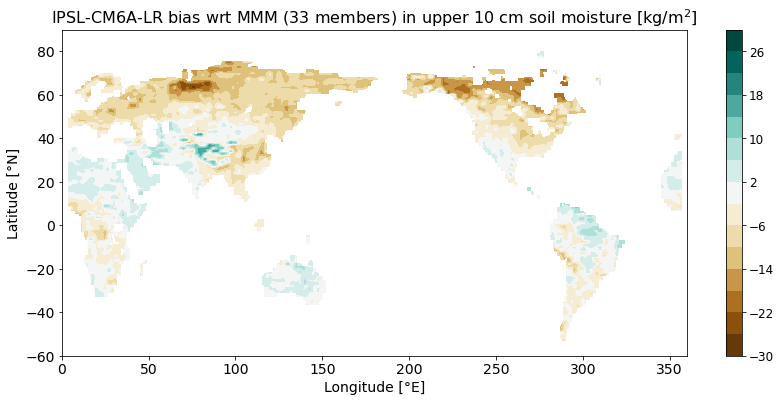

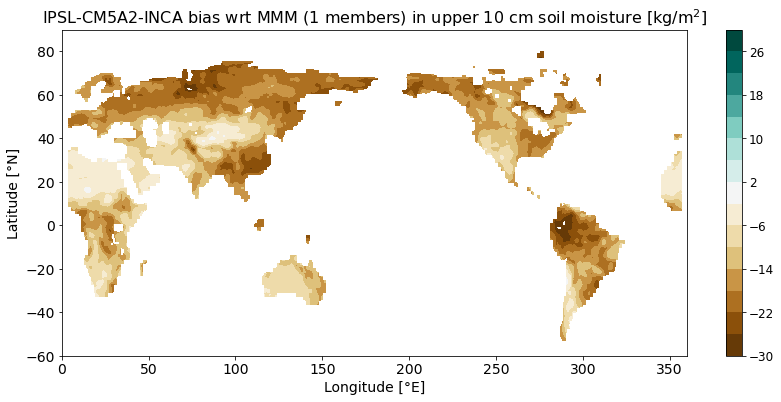

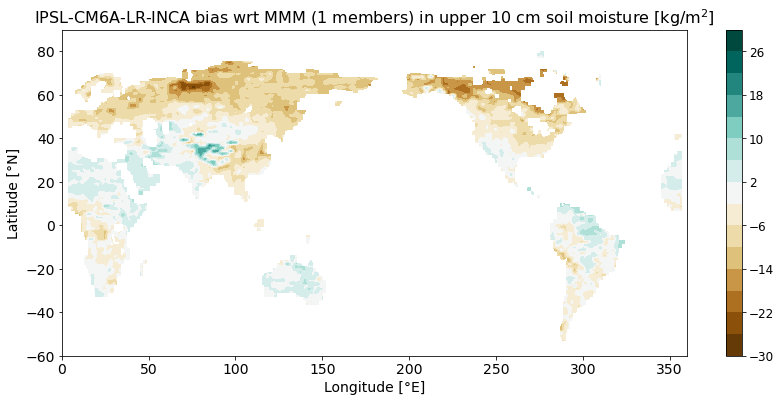

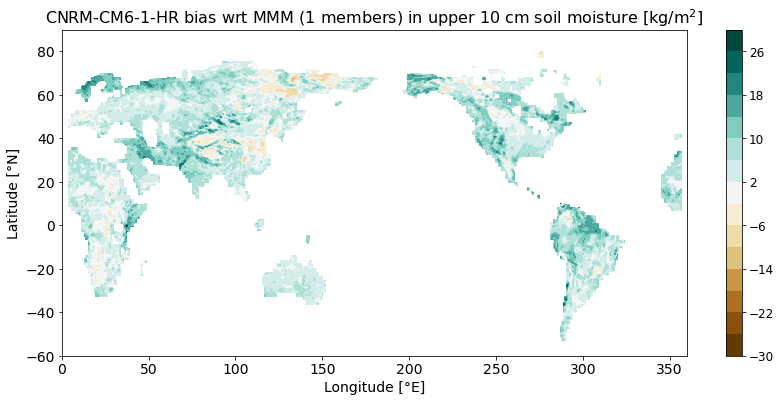

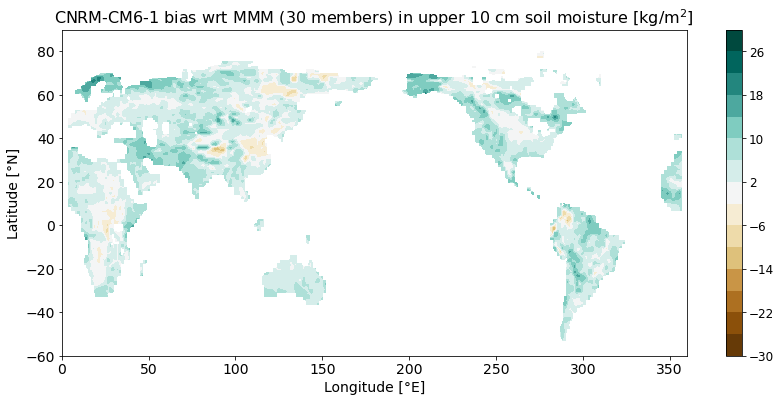

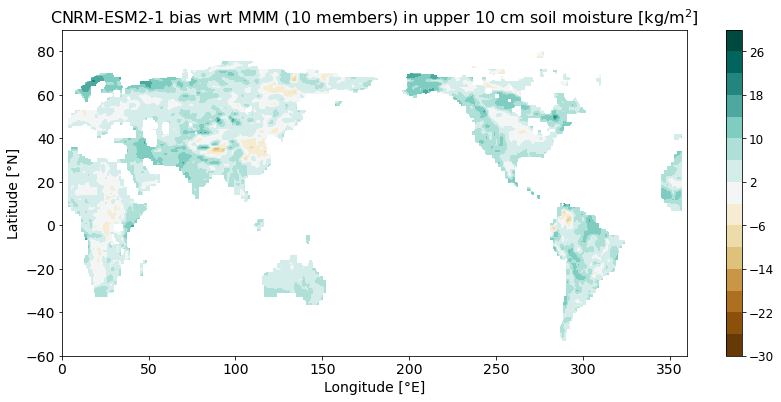

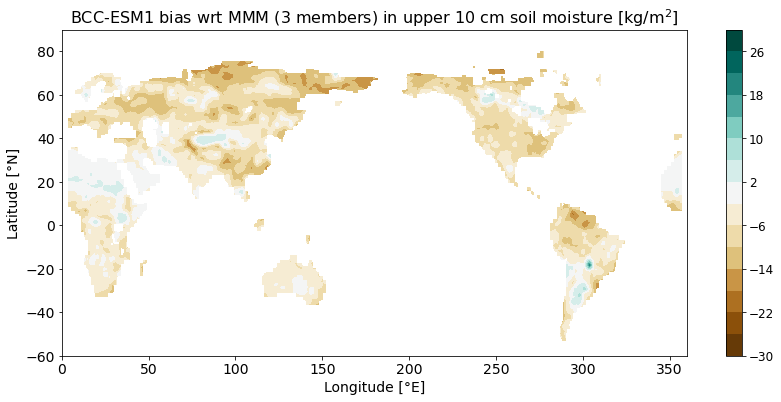

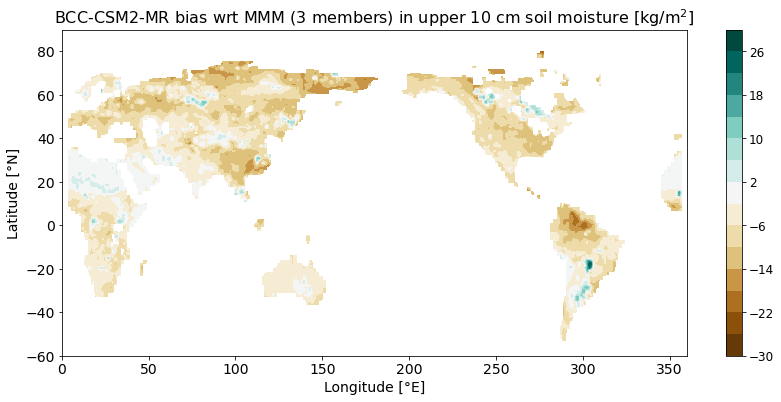

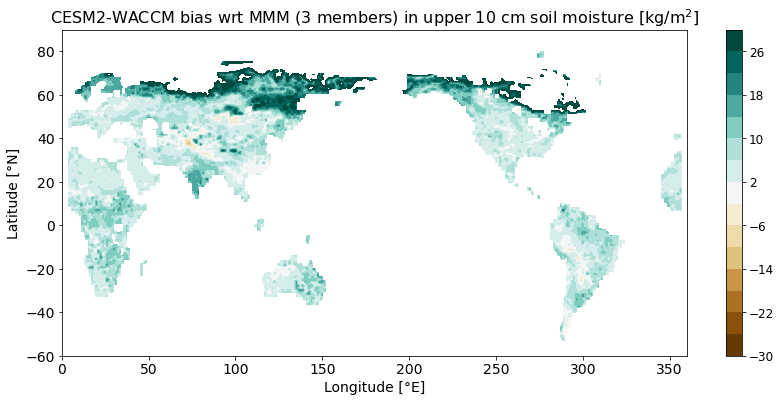

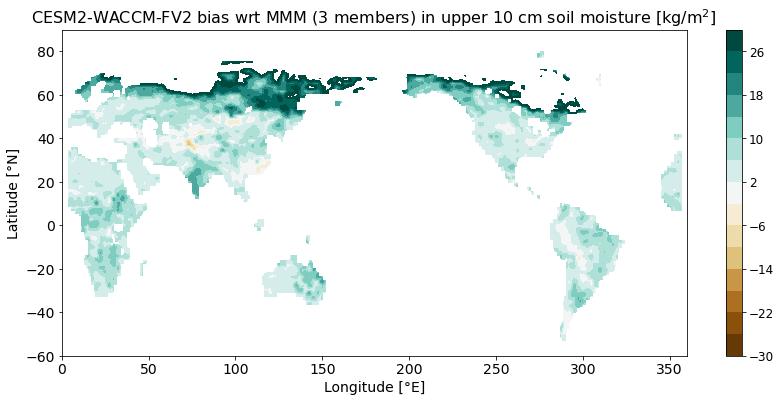

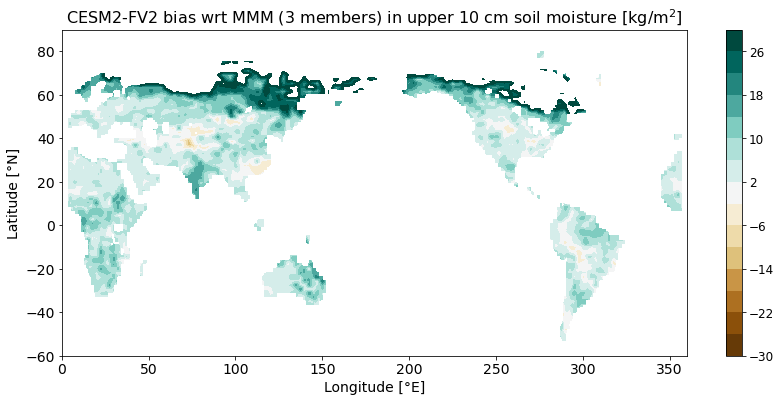

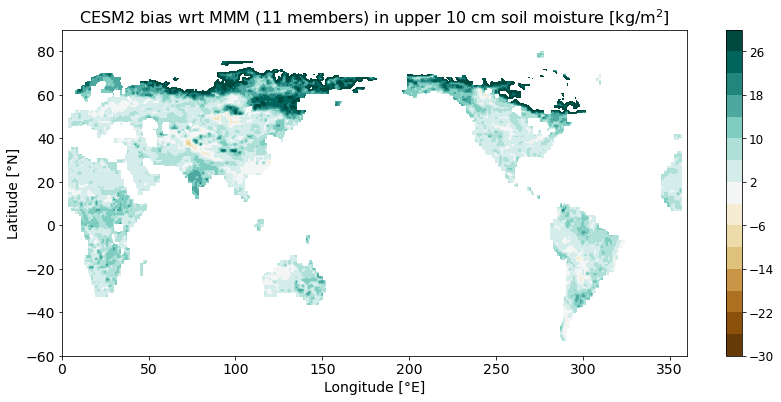

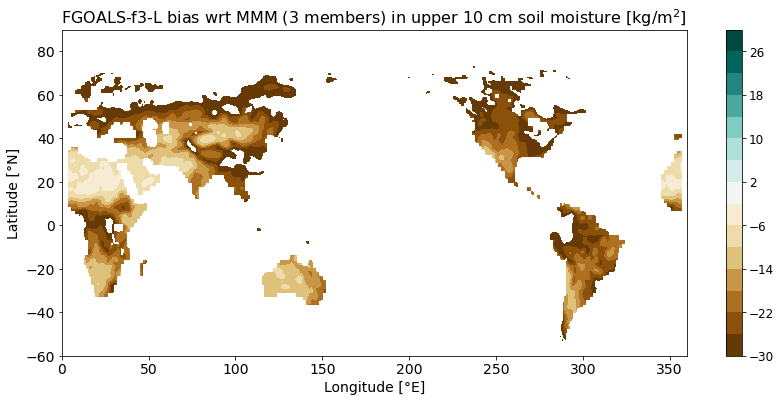

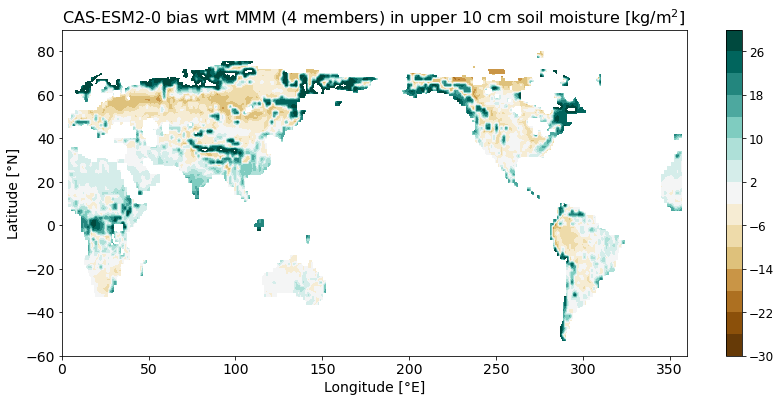

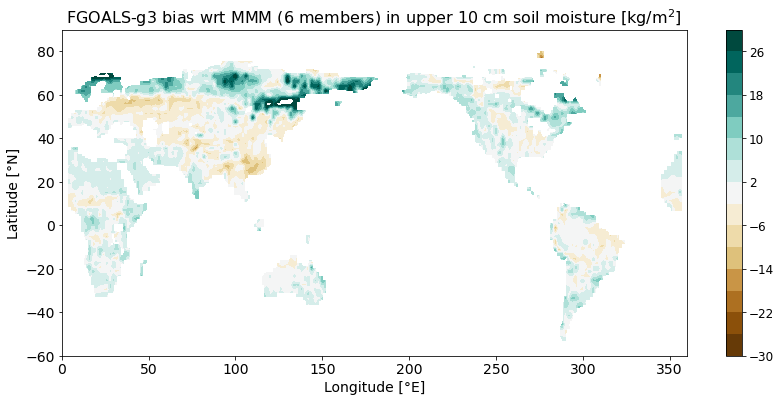

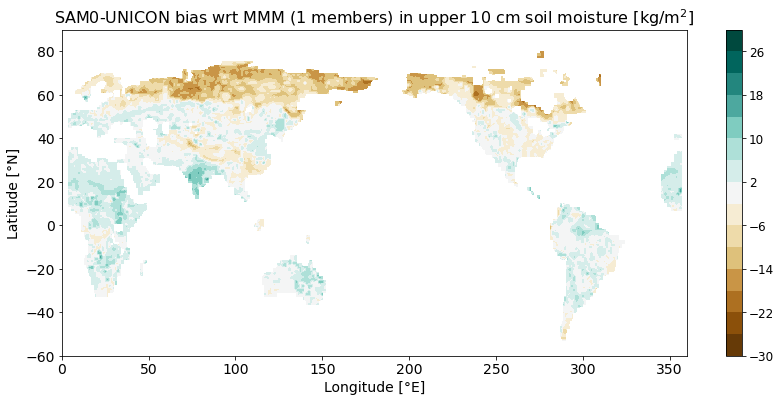

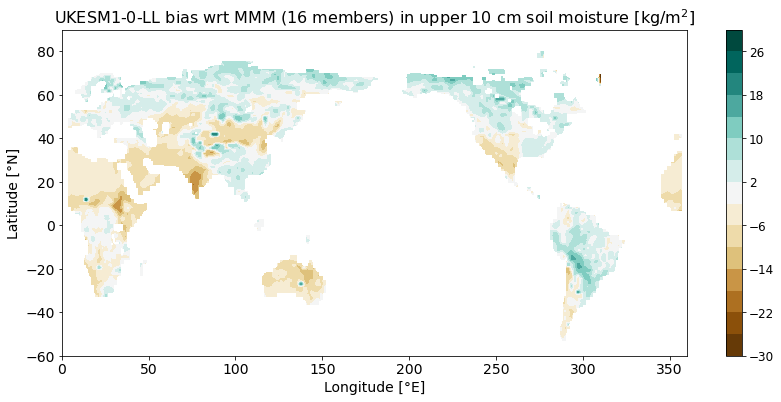

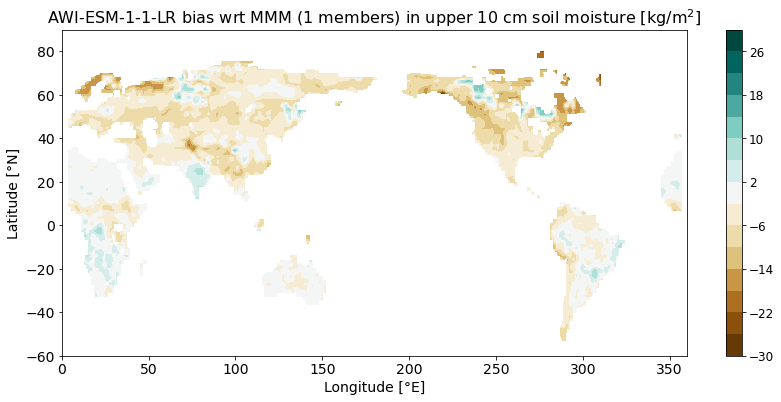

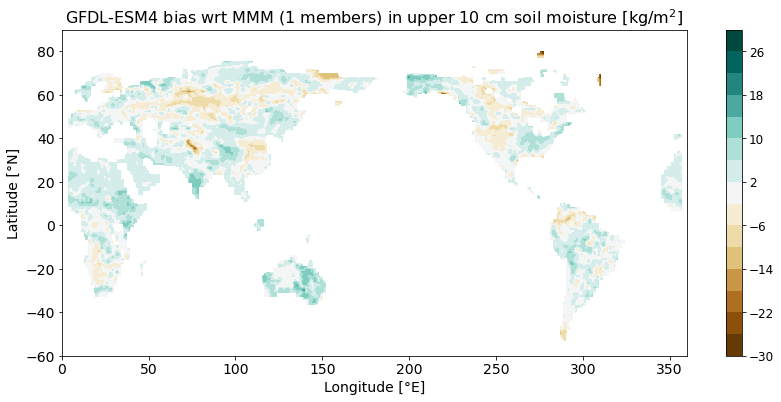

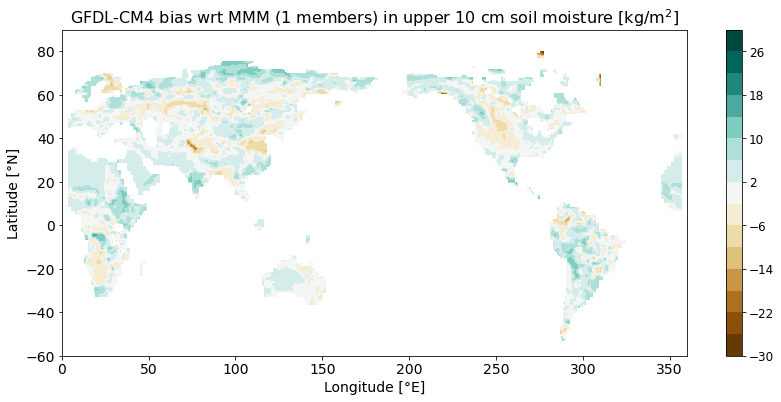

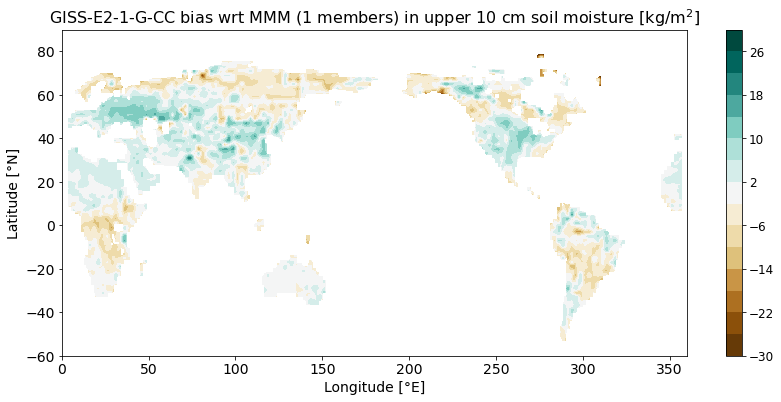

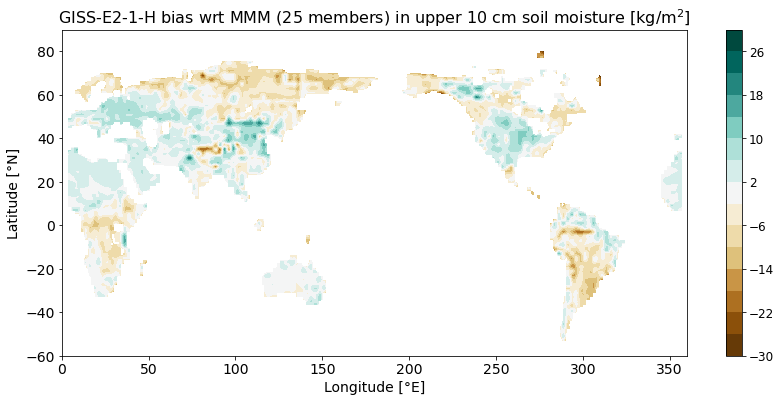

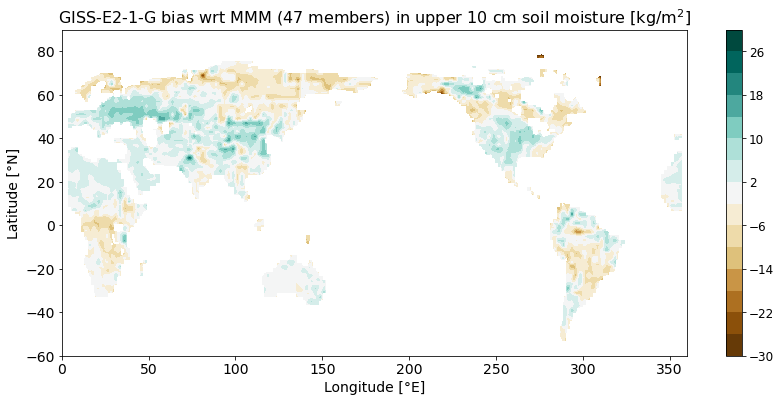

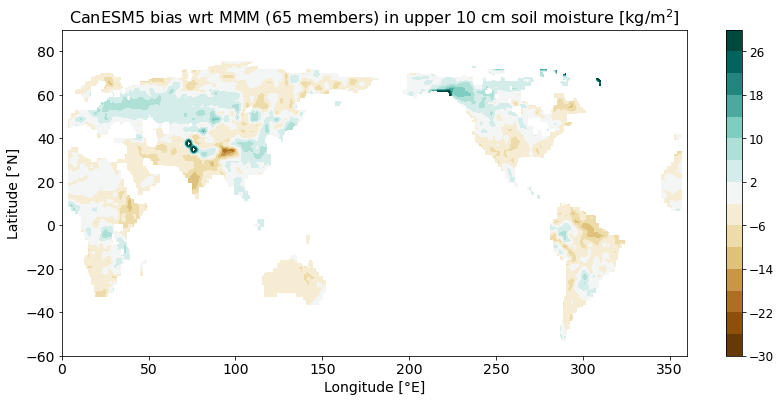

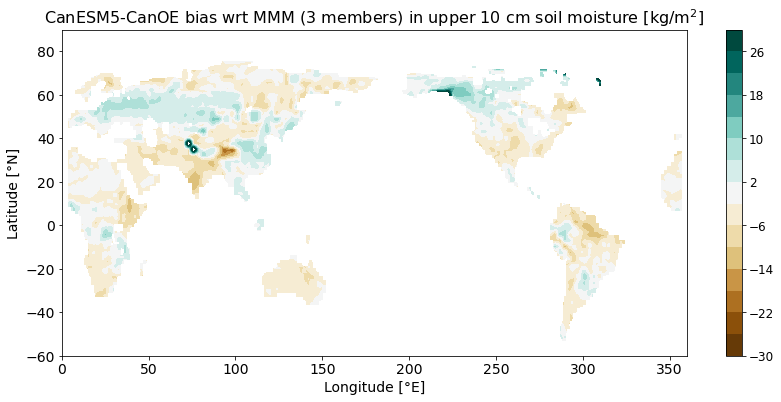

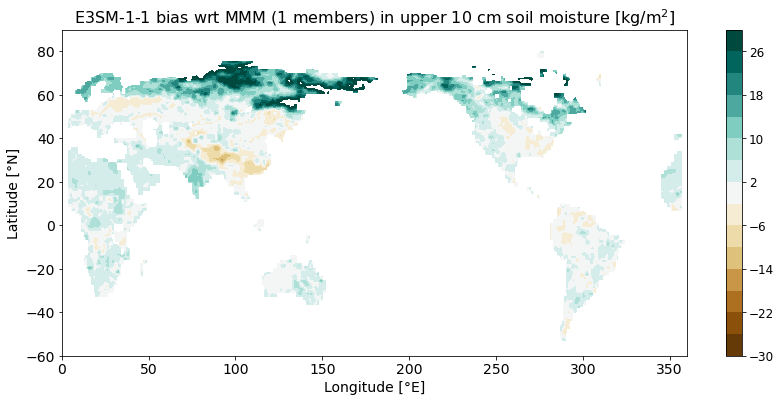

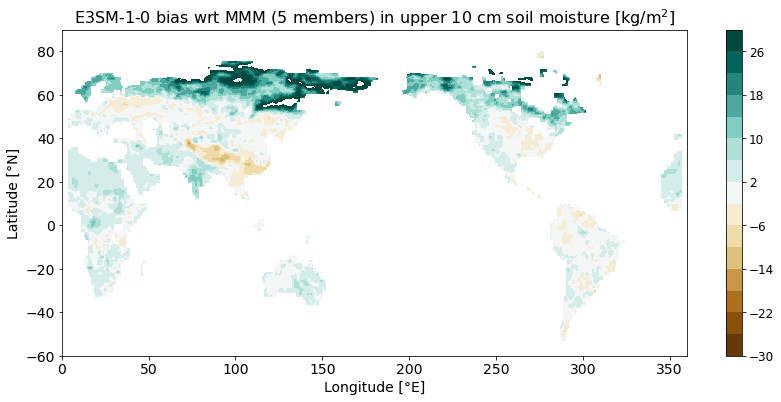

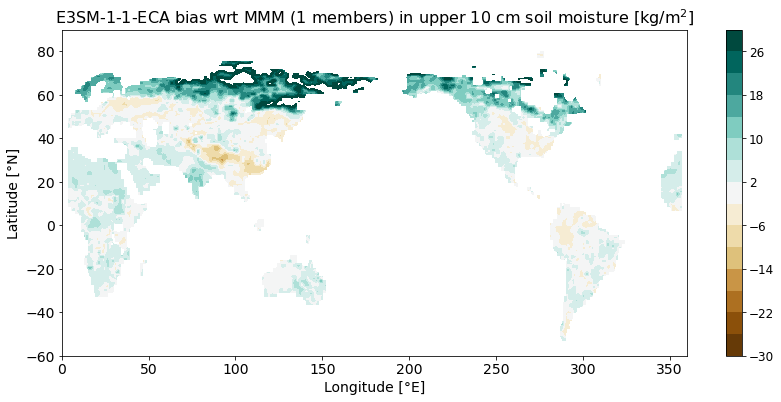

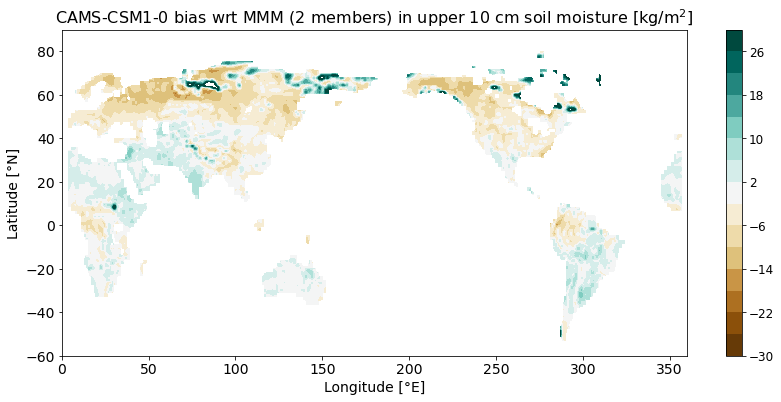

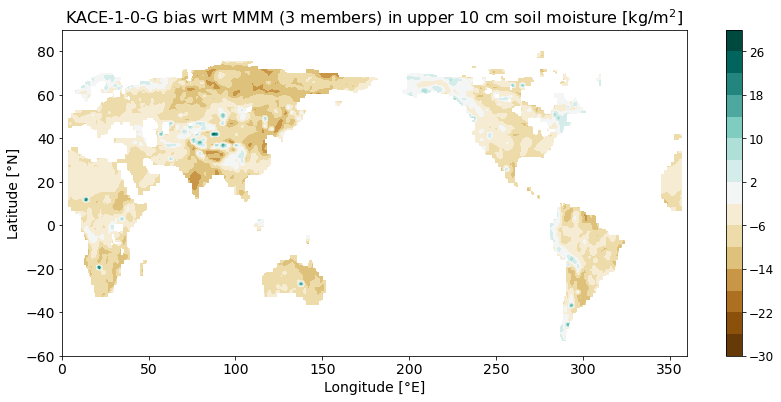

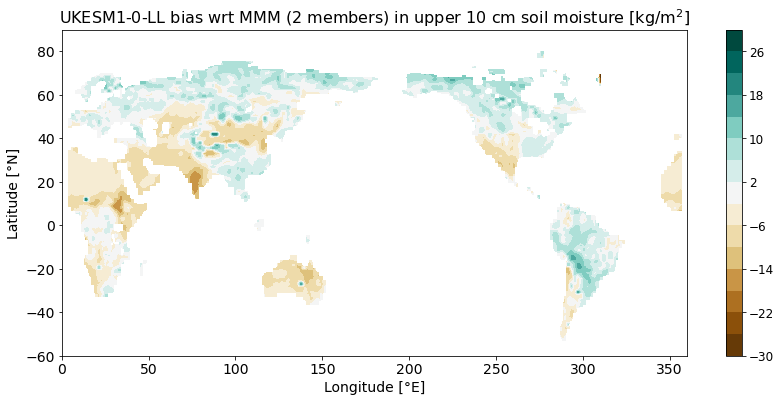

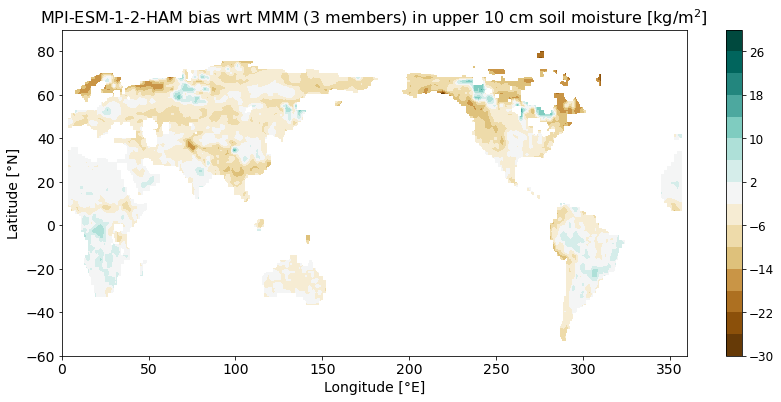

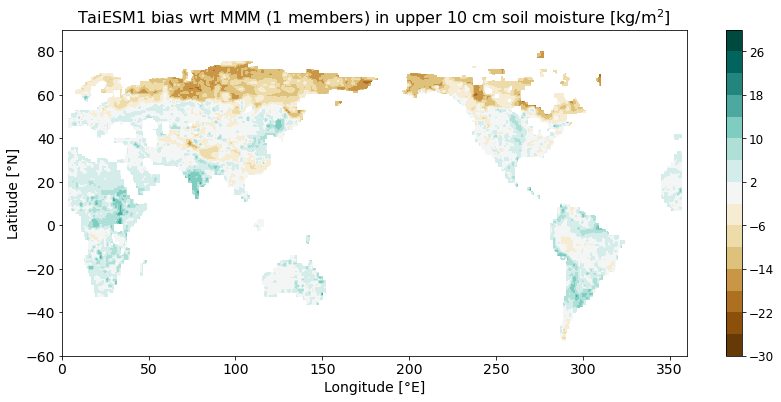

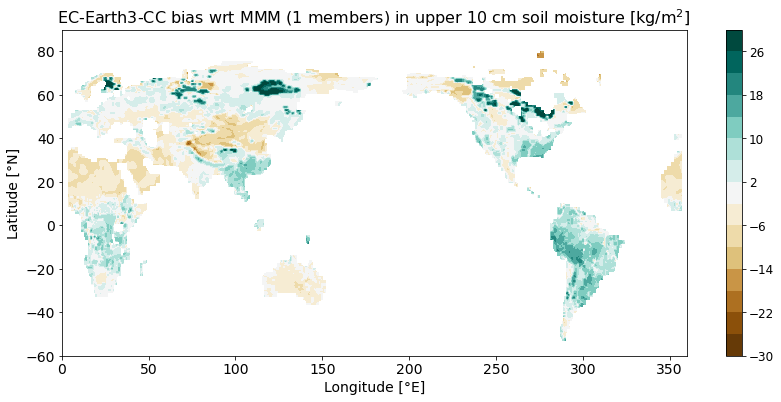

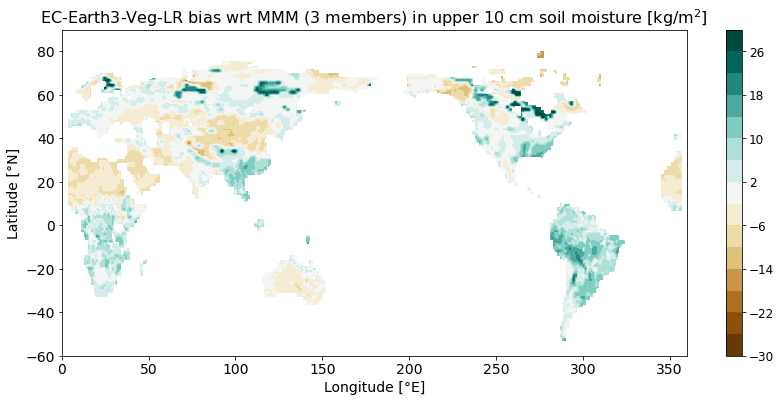

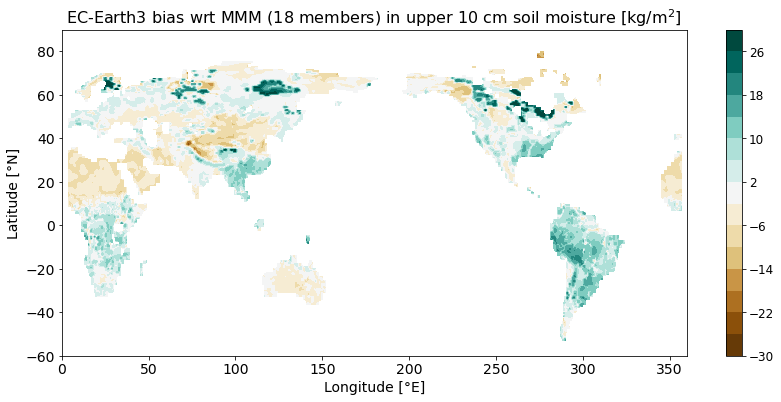

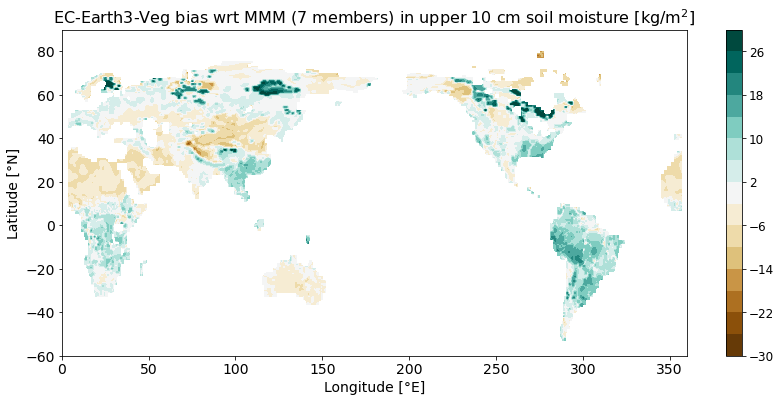

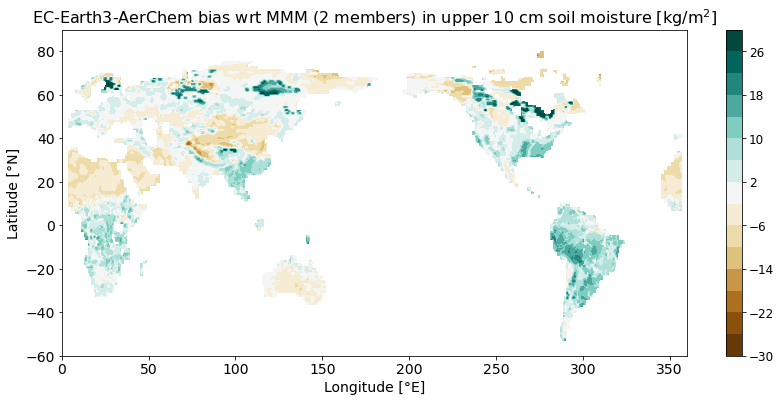

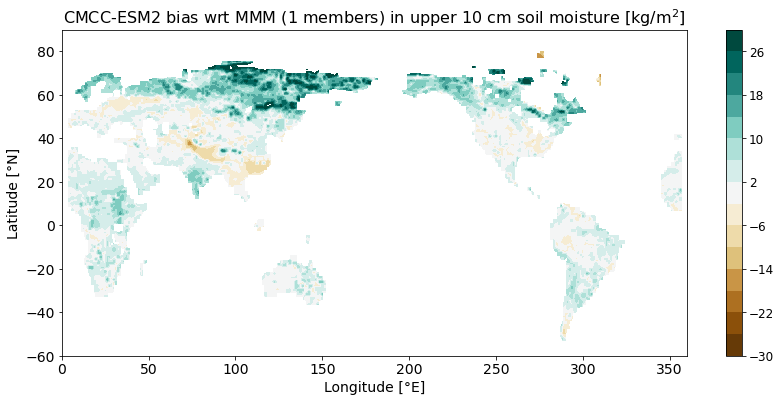

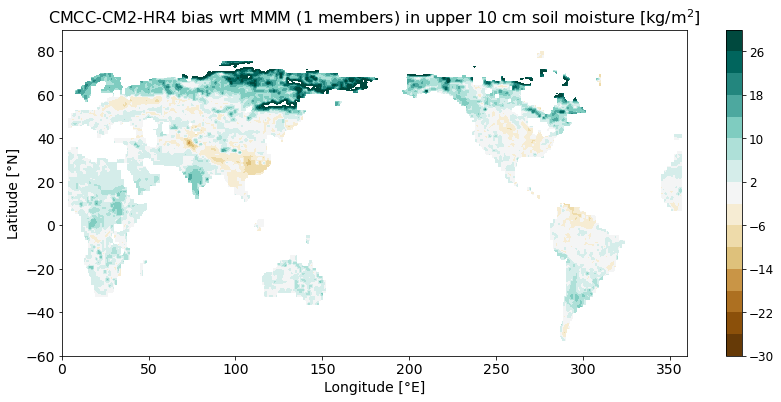

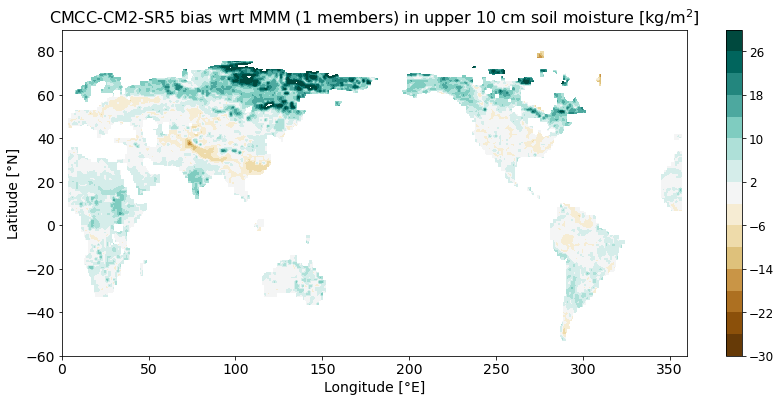

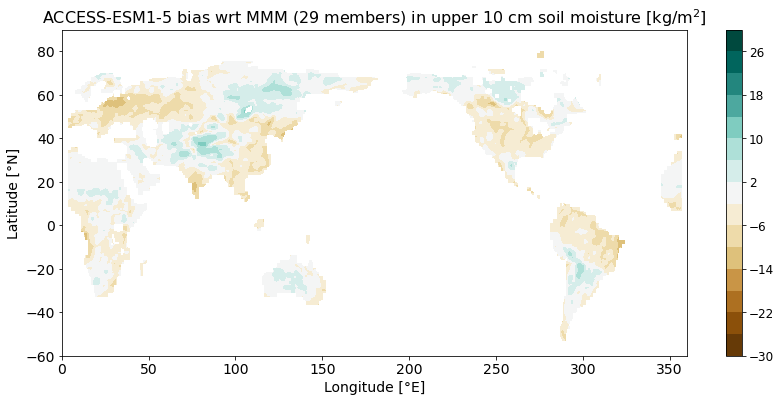

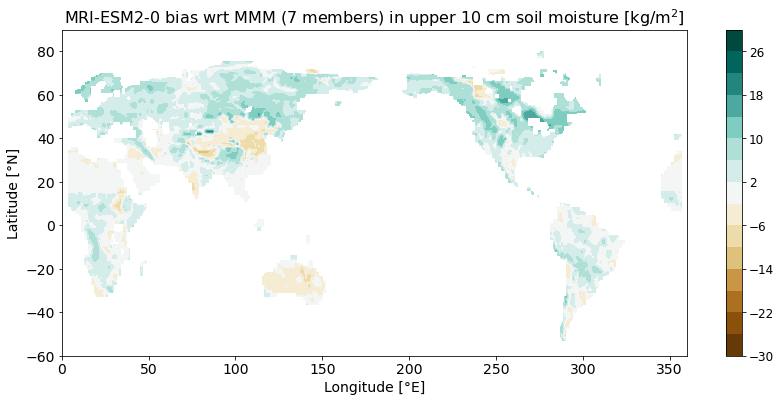

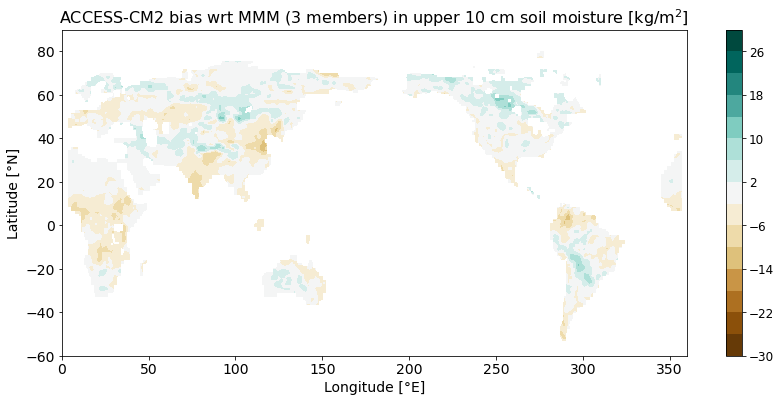

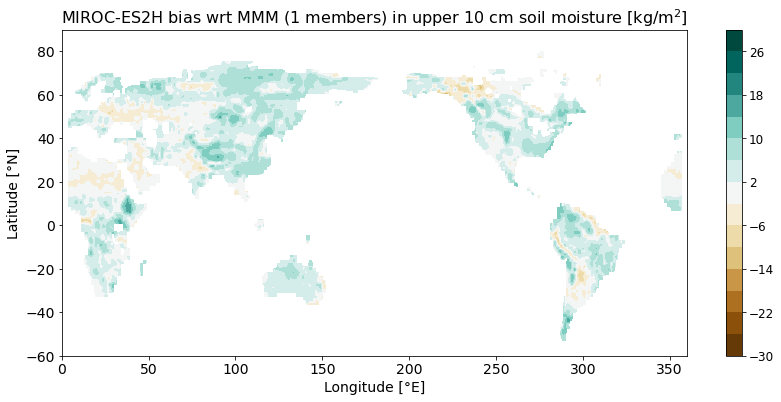

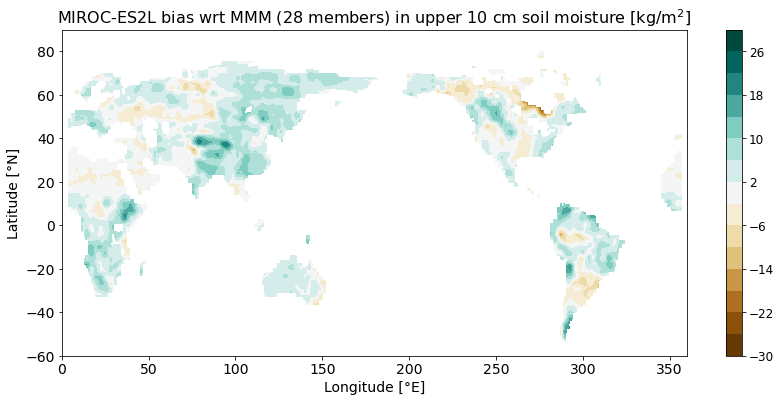

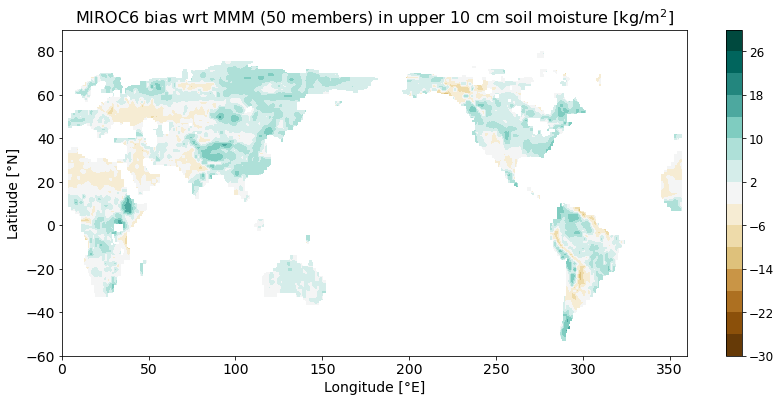

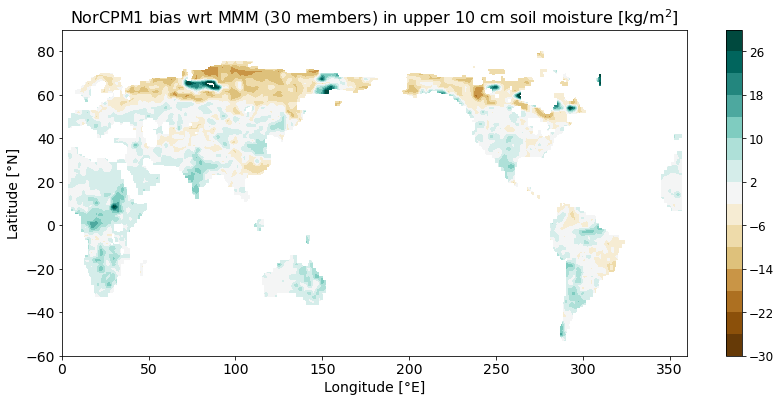

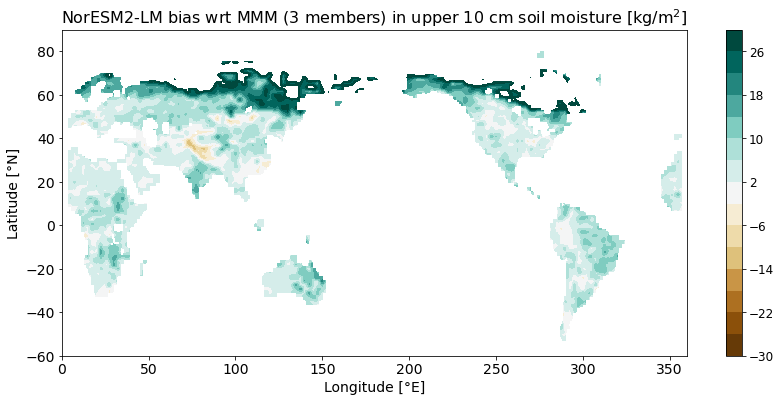

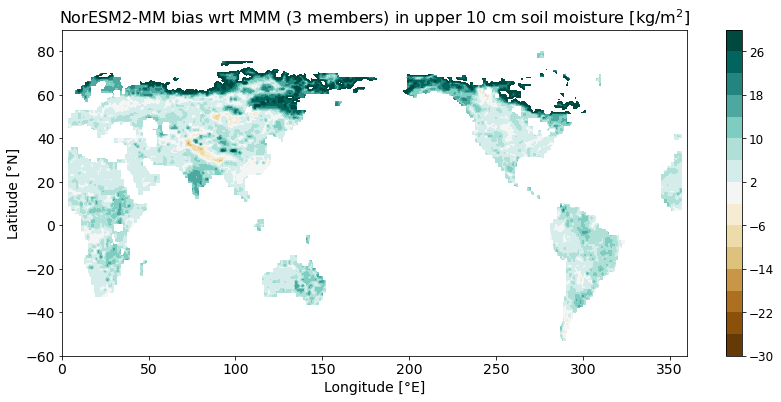

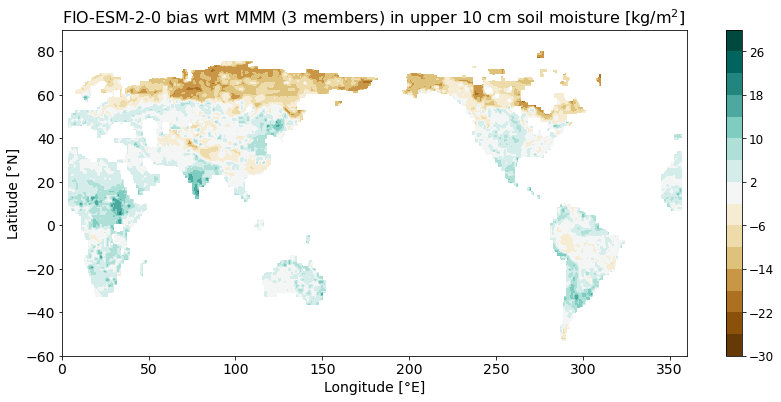

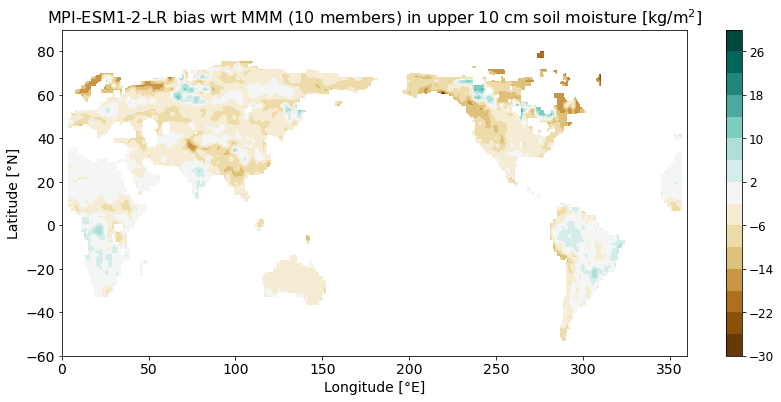

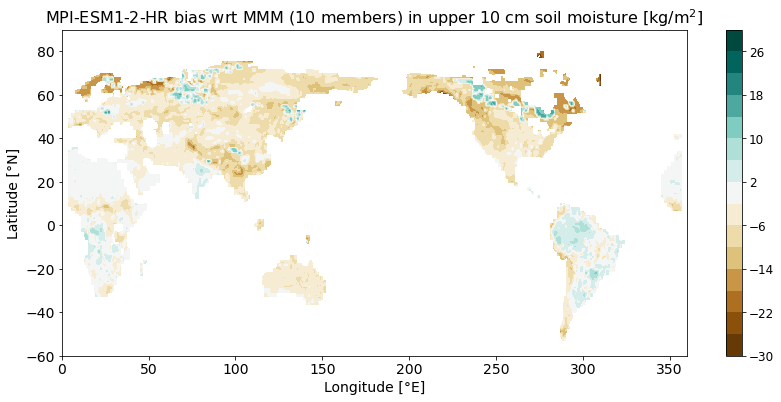

In [7]:
# Compute for each model the anomaly with respect to the MMM.

counter = 0
overall_member_counter = 0

list_of_folders = os.listdir(path2cmip6)
for folder in list_of_folders:
    list_of_models = os.listdir(path2cmip6 + folder)
    for model in list_of_models: 
        list_of_runs = os.listdir(path2cmip6 + folder + '/' + model) # 'historical', 'amip', 'piControl', 'abrupt-4xCO2', etc.
        if 'historical' in list_of_runs: #  Print the name of the models which have the historical run.
            print('# ',model)
            first_field = 1 # We want to average all the ensemble members of a given model.
            path2members = path2cmip6 + folder + '/' + model +'/historical/'
            list_of_members_etal = os.listdir(path2members)
            # Select only the ensemble members and skip the '.paths.txt' entries.
            list_of_members = [idx for idx in list_of_members_etal if idx[0].lower() == 'r'.lower()]
            print('Number of members available: '+str(len(list_of_members)))
            member_counter = 0
            for member in list_of_members: # Print the ensemble members that have info on the mrsos.
                if os.path.exists(path2members + member + '/Lmon/mrsos/gr/latest/'):
                    path2files = path2members + member + '/Lmon/mrsos/gr/latest/'
                elif os.path.exists(path2members + member + '/Lmon/mrsos/gr1/latest/'):
                    path2files = path2members + member + '/Lmon/mrsos/gr1/latest/'
                elif os.path.exists(path2members + member + '/Lmon/mrsos/gn/latest/'):
                    path2files = path2members + member + '/Lmon/mrsos/gn/latest/'
                else:
                    path2files = ''
                    
                if path2files: # If some data are available the path2file is not empty.
                    # Open and concatenate all the files whose final date is after 197901.
                    list_of_files = sorted(os.listdir(path2files))
                    # print('list_of_files =', list_of_files) # There is a member in EC-Earth that has no file but it read anyhow...
                    if list_of_files: # Check whether there are output files to be read.
                        first_file = 1
                        for ll in range(len(list_of_files)):
                            filename = list_of_files[ll]
                            final_date = filename[-9:-3]
                            if int(final_date)>197901: # Here the instant_start is re-written in the form of YYYYMM.
                                da = xr.open_dataset(path2files + filename)
                                if first_file:
                                    db = da
                                    first_file = 0
                                else:
                                    db = xr.concat([db,da],dim='time')

                        # Select the time window according to the type of time axis.
                        if db.time.dtype=='datetime64[ns]':
                            instant_start = np.datetime64('1979-01-01')
                            instant_end = np.datetime64('2014-12-31')
                        else:
                            if db.time.values[0].calendar=='noleap':
                                instant_start = cftime.DatetimeNoLeap(1979,1,1,0,0,0,0,has_year_zero=True)
                                instant_end = cftime.DatetimeNoLeap(2014,12,31,0,0,0,0,has_year_zero=True)
                            elif db.time.values[0].calendar=='360_day':
                                instant_start = cftime.Datetime360Day(1979,1,1,0,0,0,0,has_year_zero=False)
                                instant_end = cftime.Datetime360Day(2014,12,17,0,0,0,0,has_year_zero=False)     

                        # Compute the temporal mean in the time frame of interest and interpolate it on the ERA5 grid.        
                        d_mean = db.mrsos.sel(time=slice(instant_start,instant_end)).mean(dim='time')
                        d_mean_i = d_mean.interp(lon=ds_era5.longitude,lat=ds_era5.latitude)
                        if first_field:
                            d_mean4bias = d_mean_i-mean_mrsos
                            first_field=0
                        else:
                            d_mean4bias += d_mean_i-mean_mrsos
                        print(member)
                        counter += 1
                        member_counter += 1 # This is set to zero for each model.
            
            if member_counter>0: # Plot the figure if there is at least one member with a valid field.
                # Plot the map of the bias for a given model.
                mmbias_mrsos = d_mean4bias.values/member_counter

                fig = plt.figure(figsize=(14,6))
                pc = plt.contourf(lon,lat,mmbias_mrsos,levels=np.arange(-30,34,4),cmap='BrBG')
                plt.xlabel('Longitude [°E]',fontsize=14)
                plt.ylabel('Latitude [°N]',fontsize=14)
                plt.ylim([-60,90])
                plt.tick_params(axis='both',labelsize=14)

                cb = plt.colorbar(pc)
                cb.ax.tick_params(labelsize=12)

                plt.title(model+' bias wrt MMM ('+str(member_counter)+' members) in upper 10 cm soil moisture [kg/m$^2$]',fontsize=16)
                plt.savefig('mmbias_' + model + '_mrsos_1979-2014.png',bbox_inches='tight')

            overall_member_counter += member_counter
                                        
    print('----------')
    
print('Number of members actually used in total: '+ str(counter))

In [ ]:
################################## SEASONAL ###############################################

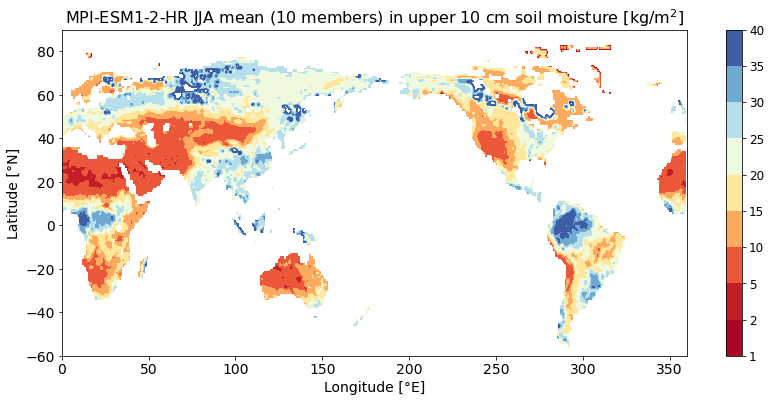

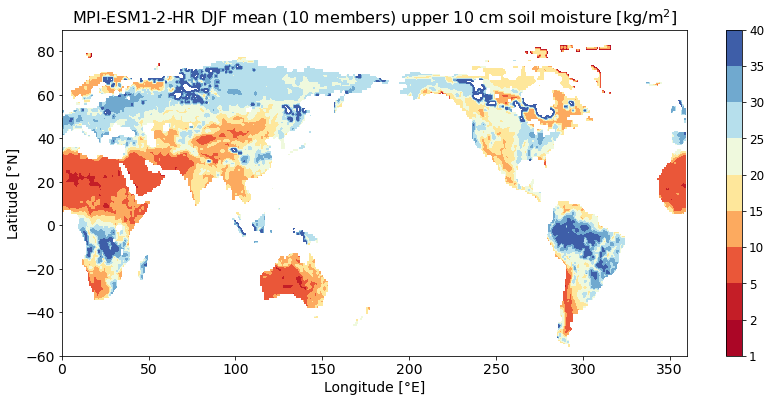

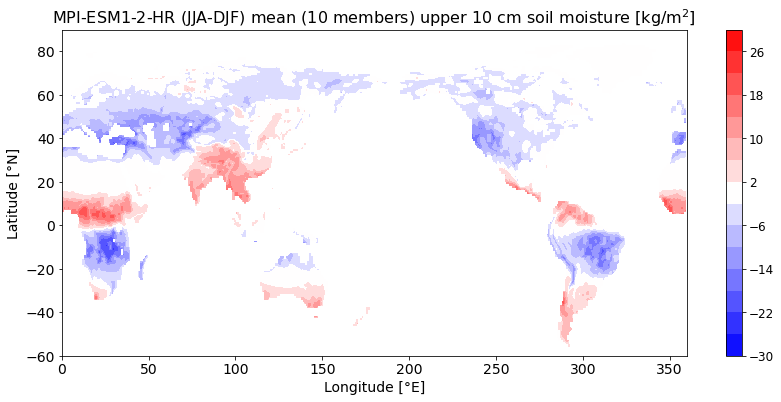

In [53]:
# Check for a single model how to compute the seasonal mean and weather it makes sense.
d_summer = db.groupby('time.season').mean('time').sel(season='JJA')
d_winter = db.groupby('time.season').mean('time').sel(season='DJF')

d_summer_i = d_summer.interp(lon=ds_era5.longitude,lat=ds_era5.latitude)
d_winter_i = d_winter.interp(lon=ds_era5.longitude,lat=ds_era5.latitude)

toplot_summer = d_summer_i.mrsos.values
toplot_winter = d_winter_i.mrsos.values

# Summer JJA
fig = plt.figure(figsize=(14,6))
pc = plt.contourf(lon,lat,toplot_summer,levels=[1,2,5,10,15,20,25,30,35,40],cmap='RdYlBu')
plt.xlabel('Longitude [°E]',fontsize=14)
plt.ylabel('Latitude [°N]',fontsize=14)
plt.ylim([-60,90])
plt.tick_params(axis='both',labelsize=14)

cb = plt.colorbar(pc)
cb.ax.tick_params(labelsize=12)

plt.title(model+' JJA mean ('+str(member_counter)+' members) in upper 10 cm soil moisture [kg/m$^2$]',fontsize=16)
plt.savefig('mean_summer_' + model + '_mrsos_1979-2014.png',bbox_inches='tight')

# Winter DJF
fig = plt.figure(figsize=(14,6))
pc = plt.contourf(lon,lat,toplot_winter,levels=[1,2,5,10,15,20,25,30,35,40],cmap='RdYlBu')
plt.xlabel('Longitude [°E]',fontsize=14)
plt.ylabel('Latitude [°N]',fontsize=14)
plt.ylim([-60,90])
plt.tick_params(axis='both',labelsize=14)

cb = plt.colorbar(pc)
cb.ax.tick_params(labelsize=12)

plt.title(model+' DJF mean ('+str(member_counter)+' members) upper 10 cm soil moisture [kg/m$^2$]',fontsize=16)
plt.savefig('mean_winter_' + model + '_mrsos_1979-2014.png',bbox_inches='tight')

# Seasonal difference
fig = plt.figure(figsize=(14,6))
pc = plt.contourf(lon,lat,toplot_summer-toplot_winter,levels=np.arange(-30,34,4),cmap='bwr')
plt.xlabel('Longitude [°E]',fontsize=14)
plt.ylabel('Latitude [°N]',fontsize=14)
plt.ylim([-60,90])
plt.tick_params(axis='both',labelsize=14)

cb = plt.colorbar(pc)
cb.ax.tick_params(labelsize=12)

plt.title(model+' (JJA-DJF) mean ('+str(member_counter)+' members) upper 10 cm soil moisture [kg/m$^2$]',fontsize=16)
plt.savefig('mean_summer-winter_' + model + '_mrsos_1979-2014.png',bbox_inches='tight')

# Midlatitudes: in winter (DJF, blue shades) it rains more in the boreal hemisphere and in summer (JJA, red shades) it rains more in the austral hemisphere.
# Tropics: in summer the ITCZ is shifted to the north and in winter it is shifted to the south.
# It looks very reasonable.

####################### IN THE FIGURES A SINGLE MEMBER IS CONSIDERED!!!!! AND NOT TEN OF THEM AS DISPLAYED IN THE TITLE!!!!!
############### WE NEED TO OVERWRITE THIS FIGURE!!!!!!!!!!!!!!!!!!!

In [5]:
# Compute the MMM, MMSTD and MMbias for a specific season. In the same way as before: every ensemble member has the same weight.

label_season = 'JJA'

first_field = 1
counter = 0
overall_member_counter = 0

list_of_folders = os.listdir(path2cmip6)
for folder in list_of_folders:
    list_of_models = os.listdir(path2cmip6 + folder)
    for model in list_of_models: 
        list_of_runs = os.listdir(path2cmip6 + folder + '/' + model) # 'historical', 'amip', 'piControl', 'abrupt-4xCO2', etc.
        if 'historical' in list_of_runs: #  Print the name of the models which have the historical run.
            print('# ',model)
            path2members = path2cmip6 + folder + '/' + model +'/historical/'
            list_of_members_etal = os.listdir(path2members)
            # Select only the ensemble members and skip the '.paths.txt' entries.
            list_of_members = [idx for idx in list_of_members_etal if idx[0].lower() == 'r'.lower()]
            member_counter = 0
            for member in list_of_members: # Print the ensemble members that have info on the mrsos.
                if os.path.exists(path2members + member + '/Lmon/mrsos/gr/latest/'):
                    path2files = path2members + member + '/Lmon/mrsos/gr/latest/'
                    member_counter += 1
                elif os.path.exists(path2members + member + '/Lmon/mrsos/gr1/latest/'):
                    path2files = path2members + member + '/Lmon/mrsos/gr1/latest/'
                    member_counter += 1
                elif os.path.exists(path2members + member + '/Lmon/mrsos/gn/latest/'):
                    path2files = path2members + member + '/Lmon/mrsos/gn/latest/'
                    member_counter += 1
                else:
                    path2files = ''
                    
                if path2files: # If some data are available the path2file is not empty.
                    # Open and concatenate all the files whose final date is after 197901.
                    list_of_files = sorted(os.listdir(path2files))
                    # print('list_of_files =', list_of_files) # There is a member in EC-Earth that has no file but it read anyhow...
                    if list_of_files: # Check whether there are output files to be read.
                        first_file = 1
                        for ll in range(len(list_of_files)):
                            filename = list_of_files[ll]
                            final_date = filename[-9:-3]
                            if int(final_date)>197901: # Here the instant_start is re-written in the form of YYYYMM.
                                da = xr.open_dataset(path2files + filename)
                                if first_file:
                                    db = da
                                    first_file = 0
                                else:
                                    db = xr.concat([db,da],dim='time')

                        # Select the time window according to the type of time axis.
                        if db.time.dtype=='datetime64[ns]':
                            instant_start = np.datetime64('1979-01-01')
                            instant_end = np.datetime64('2014-12-31')
                        else:
                            if db.time.values[0].calendar=='noleap':
                                instant_start = cftime.DatetimeNoLeap(1979,1,1,0,0,0,0,has_year_zero=True)
                                instant_end = cftime.DatetimeNoLeap(2014,12,31,0,0,0,0,has_year_zero=True)
                            elif db.time.values[0].calendar=='360_day':
                                instant_start = cftime.Datetime360Day(1979,1,1,0,0,0,0,has_year_zero=False)
                                instant_end = cftime.Datetime360Day(2014,12,17,0,0,0,0,has_year_zero=False)     

                        # Compute the seasonal mean in the time frame of interest and interpolate it on the ERA5 grid.
                        d_time = db.mrsos.sel(time=slice(instant_start,instant_end)) # Select the time window.
                        d_season = d_time.groupby('time.season').mean('time').sel(season=label_season) # Select the season.
                        
                        if first_field:
                            d_season_i = d_season.interp(lon=ds_era5.longitude,lat=ds_era5.latitude) # Interpolate.
                            first_field=0
                        else:
                            d_season_i += d_season.interp(lon=ds_era5.longitude,lat=ds_era5.latitude) # Interpolate.
                        counter += 1

                print('Ensemble member '+str(member_counter)+' out of '+str(len(list_of_members)))

            overall_member_counter += member_counter
                                        
    print('----------')
    
print(str(overall_member_counter) +' members have mrsos among their Lmon variables.')   
print('Number of members actually used: '+ str(counter))


#  IPSL-CM6A-LR
Ensemble member 1 out of 33
Ensemble member 2 out of 33
Ensemble member 3 out of 33
Ensemble member 4 out of 33
Ensemble member 5 out of 33
Ensemble member 6 out of 33
Ensemble member 7 out of 33
Ensemble member 8 out of 33
Ensemble member 9 out of 33
Ensemble member 10 out of 33
Ensemble member 11 out of 33
Ensemble member 12 out of 33
Ensemble member 13 out of 33
Ensemble member 14 out of 33
Ensemble member 15 out of 33
Ensemble member 16 out of 33
Ensemble member 17 out of 33
Ensemble member 18 out of 33
Ensemble member 19 out of 33
Ensemble member 20 out of 33
Ensemble member 21 out of 33
Ensemble member 22 out of 33
Ensemble member 23 out of 33
Ensemble member 24 out of 33
Ensemble member 25 out of 33
Ensemble member 26 out of 33
Ensemble member 27 out of 33
Ensemble member 28 out of 33
Ensemble member 29 out of 33
Ensemble member 30 out of 33
Ensemble member 31 out of 33
Ensemble member 32 out of 33
Ensemble member 33 out of 33
#  IPSL-CM5A2-INCA
Ensemble member 1

/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 1 out of 3


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 2 out of 3


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 3 out of 3
#  CESM2-WACCM-FV2
Ensemble member 1 out of 3


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 2 out of 3


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 3 out of 3
#  CESM2-FV2


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 1 out of 4
Ensemble member 2 out of 4
Ensemble member 2 out of 4


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 3 out of 4
#  CESM2


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 1 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 2 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 3 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 4 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 5 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 6 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 7 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 8 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 9 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 10 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 11 out of 11
----------
#  FGOALS-f3-L
Ensemble member 1 out of 3
Ensemble member 2 out of 3
Ensemble member 3 out of 3
#  CAS-ESM2-0
Ensemble member 1 out of 4
Ensemble member 2 out of 4
Ensemble member 3 out of 4
Ensemble member 4 out of 4
#  FGOALS-g3
Ensemble member 1 out of 6
Ensemble member 2 out of 6
Ensemble member 3 out of 6
Ensemble member 4 out of 6
Ensemble member 5 out of 6
Ensemble member 6 out of 6
----------
#  SAM0-UNICON
Ensemble member 1 out of 1
----------
#  UKESM1-0-LL
Ensemble member 1 out of 16
Ensemble member 2 out of 16
Ensemble member 3 out of 16
Ensemble member 4 out of 16
Ensemble member 5 out of 16
Ensemble member 6 out of 16
Ensemble member 7 out of 16
Ensemble member 8 out of 16
Ensemble member 9 out of 16
Ensemble member 10 out of 16
Ensemble member 11 out of 16
Ensemble member 12 out of 16
Ensemble member 13 out of 16
Ensemble member 14 out of 16
Ensemble member 15 out of 16
Ensemble member 16 out of 16
#  HadGEM3-GC31-LL
Ensemble membe

In [10]:
# Save the seasonal MMM as netcdf file.

d_mean_season_mrsos = d_season_i.assign_attrs(counter=counter, units='kg/m2')
#d_mean_season_mrsos.assign_attrs(counter=str(counter), units='kg/m2')
d_mean_season_mrsos.to_netcdf(label_season + '_MMM_mrsos')

d_mean_season_mrsos.attrs

{'counter': 505, 'units': 'kg/m2'}

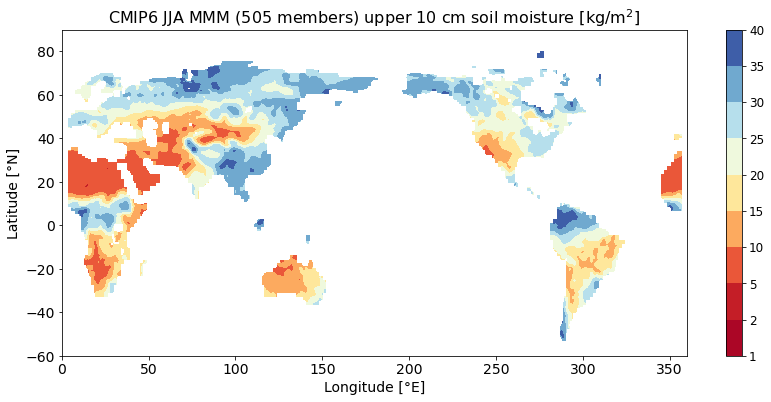

In [7]:
# Read the netcdf file with the seasonal MMM previously computed.

label_season = 'JJA'

ds = xr.open_dataset(label_season + '_MMM_mrsos')
counter = ds.mrsos.attrs['counter']
mean_season_mrsos = ds.mrsos.values/counter

lon = ds.longitude.values
lat = ds.latitude.values

fig = plt.figure(figsize=(14,6))
pc = plt.contourf(lon,lat,mean_season_mrsos,levels=[1,2,5,10,15,20,25,30,35,40],cmap='RdYlBu')#,shading='nearest')
plt.xlabel('Longitude [°E]',fontsize=14)
plt.ylabel('Latitude [°N]',fontsize=14)
plt.ylim([-60,90])
plt.tick_params(axis='both',labelsize=14)

cb = plt.colorbar(pc)
cb.ax.tick_params(labelsize=12)

plt.title('CMIP6 ' + label_season + ' MMM ('+str(counter)+' members) upper 10 cm soil moisture [kg/m$^2$]',fontsize=16)
plt.savefig('mmm_'+label_season+'_mrsos_1979-2014_allmodels.png',bbox_inches='tight')

mean_summer_mrsos = mean_season_mrsos
#mean_winter_mrsos = mean_season_mrsoslabel_season

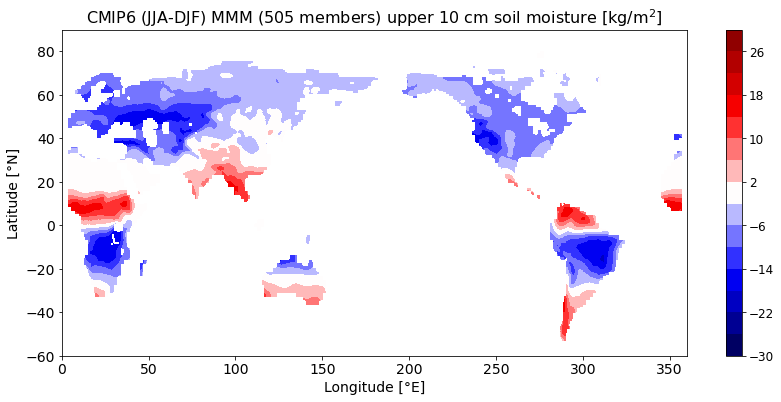

In [13]:
# Plot the summer-winter MMM difference.
# For this, first compute the summer MMM and then the winter MMM with the previous cell.

fig = plt.figure(figsize=(14,6))
pc = plt.contourf(lon,lat,mean_summer_mrsos-mean_winter_mrsos,levels=np.arange(-30,34,4),cmap='seismic')
plt.xlabel('Longitude [°E]',fontsize=14)
plt.ylabel('Latitude [°N]',fontsize=14)
plt.ylim([-60,90])
plt.tick_params(axis='both',labelsize=14)

cb = plt.colorbar(pc)
cb.ax.tick_params(labelsize=12)

plt.title('CMIP6 (JJA-DJF) MMM ('+str(counter)+' members) upper 10 cm soil moisture [kg/m$^2$]',fontsize=16)
plt.savefig('mmm_JJA-DJF_mrsos_1979-2014_allmodels.png',bbox_inches='tight')

#  IPSL-CM6A-LR
Number of members available: 33
[-1.82924895]
['IPSL-CM6A-LR']
[33]
#  IPSL-CM5A2-INCA
Number of members available: 1
[ -1.82924895 -12.2376442 ]
['IPSL-CM6A-LR', 'IPSL-CM5A2-INCA']
[33, 1]
#  IPSL-CM6A-LR-INCA
Number of members available: 1
[ -1.82924895 -12.2376442   -1.19617462]
['IPSL-CM6A-LR', 'IPSL-CM5A2-INCA', 'IPSL-CM6A-LR-INCA']
[33, 1, 1]
----------
#  KIOST-ESM
Number of members available: 1
----------
#  CIESM
Number of members available: 3
----------
#  CNRM-CM6-1-HR
Number of members available: 1
[ -1.82924895 -12.2376442   -1.19617462   3.99657444]
['IPSL-CM6A-LR', 'IPSL-CM5A2-INCA', 'IPSL-CM6A-LR-INCA', 'CNRM-CM6-1-HR']
[33, 1, 1, 1]
#  CNRM-CM6-1
Number of members available: 30
[ -1.82924895 -12.2376442   -1.19617462   3.99657444   3.26905148]
['IPSL-CM6A-LR', 'IPSL-CM5A2-INCA', 'IPSL-CM6A-LR-INCA', 'CNRM-CM6-1-HR', 'CNRM-CM6-1']
[33, 1, 1, 1, 30]
#  CNRM-ESM2-1
Number of members available: 11
[ -1.82924895 -12.2376442   -1.19617462   3.99657444   3.269

/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[ -1.82924895 -12.2376442   -1.19617462   3.99657444   3.26905148
   3.02836993  -7.16254705  -9.80950151   2.11573908]
['IPSL-CM6A-LR', 'IPSL-CM5A2-INCA', 'IPSL-CM6A-LR-INCA', 'CNRM-CM6-1-HR', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'BCC-ESM1', 'BCC-CSM2-MR', 'CESM2-WACCM']
[33, 1, 1, 1, 30, 10, 3, 3, 3]
#  CESM2-WACCM-FV2
Number of members available: 3


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[ -1.82924895 -12.2376442   -1.19617462   3.99657444   3.26905148
   3.02836993  -7.16254705  -9.80950151   2.11573908   3.09876167]
['IPSL-CM6A-LR', 'IPSL-CM5A2-INCA', 'IPSL-CM6A-LR-INCA', 'CNRM-CM6-1-HR', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'BCC-ESM1', 'BCC-CSM2-MR', 'CESM2-WACCM', 'CESM2-WACCM-FV2']
[33, 1, 1, 1, 30, 10, 3, 3, 3, 3]
#  CESM2-FV2
Number of members available: 4


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[ -1.82924895 -12.2376442   -1.19617462   3.99657444   3.26905148
   3.02836993  -7.16254705  -9.80950151   2.11573908   3.09876167
   2.25803028]
['IPSL-CM6A-LR', 'IPSL-CM5A2-INCA', 'IPSL-CM6A-LR-INCA', 'CNRM-CM6-1-HR', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'BCC-ESM1', 'BCC-CSM2-MR', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'CESM2-FV2']
[33, 1, 1, 1, 30, 10, 3, 3, 3, 3, 3]
#  CESM2
Number of members available: 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packa

[ -1.82924895 -12.2376442   -1.19617462   3.99657444   3.26905148
   3.02836993  -7.16254705  -9.80950151   2.11573908   3.09876167
   2.25803028   2.32254418]
['IPSL-CM6A-LR', 'IPSL-CM5A2-INCA', 'IPSL-CM6A-LR-INCA', 'CNRM-CM6-1-HR', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'BCC-ESM1', 'BCC-CSM2-MR', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'CESM2-FV2', 'CESM2']
[33, 1, 1, 1, 30, 10, 3, 3, 3, 3, 3, 11]
----------
#  FGOALS-f3-L
Number of members available: 3
[ -1.82924895 -12.2376442   -1.19617462   3.99657444   3.26905148
   3.02836993  -7.16254705  -9.80950151   2.11573908   3.09876167
   2.25803028   2.32254418 -19.38716099]
['IPSL-CM6A-LR', 'IPSL-CM5A2-INCA', 'IPSL-CM6A-LR-INCA', 'CNRM-CM6-1-HR', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'BCC-ESM1', 'BCC-CSM2-MR', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'CESM2-FV2', 'CESM2', 'FGOALS-f3-L']
[33, 1, 1, 1, 30, 10, 3, 3, 3, 3, 3, 11, 3]
#  CAS-ESM2-0
Number of members available: 4
[ -1.82924895 -12.2376442   -1.19617462   3.99657444   3.26905148
   3.02836993  -7.16254705 

<ipython-input-50-6abf39417ab6>:94: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(14,6))


#  GISS-E2-2-H
Number of members available: 5
#  GISS-E2-1-H
Number of members available: 25
[ -1.82924895 -12.2376442   -1.19617462   3.99657444   3.26905148
   3.02836993  -7.16254705  -9.80950151   2.11573908   3.09876167
   2.25803028   2.32254418 -19.38716099  -2.53608927   0.33056543
  -0.5681529   -2.57980195  -4.17208493   0.83508058   0.17557345
   5.91816296   5.93639076]
['IPSL-CM6A-LR', 'IPSL-CM5A2-INCA', 'IPSL-CM6A-LR-INCA', 'CNRM-CM6-1-HR', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'BCC-ESM1', 'BCC-CSM2-MR', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'CESM2-FV2', 'CESM2', 'FGOALS-f3-L', 'CAS-ESM2-0', 'FGOALS-g3', 'SAM0-UNICON', 'UKESM1-0-LL', 'AWI-ESM-1-1-LR', 'GFDL-ESM4', 'GFDL-CM4', 'GISS-E2-1-G-CC', 'GISS-E2-1-H']
[33, 1, 1, 1, 30, 10, 3, 3, 3, 3, 3, 11, 3, 4, 6, 1, 16, 1, 1, 1, 1, 25]
#  GISS-E2-2-G
Number of members available: 6
#  GISS-E2-1-G
Number of members available: 47
[ -1.82924895 -12.2376442   -1.19617462   3.99657444   3.26905148
   3.02836993  -7.16254705  -9.80950151   2.11573

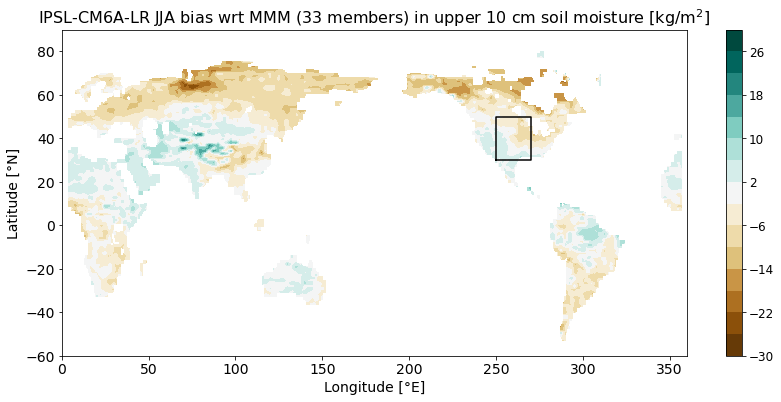

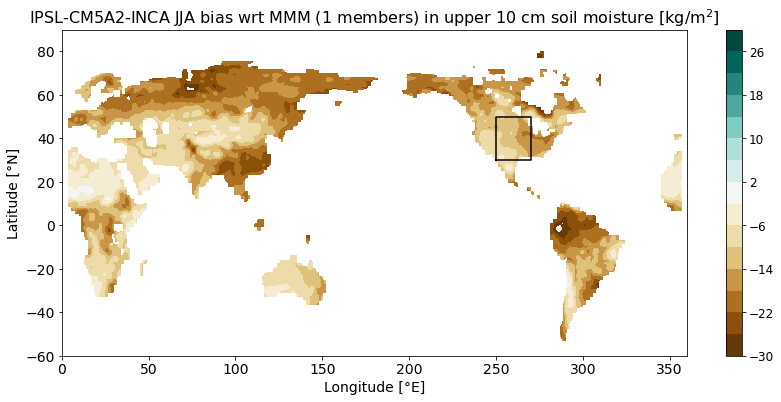

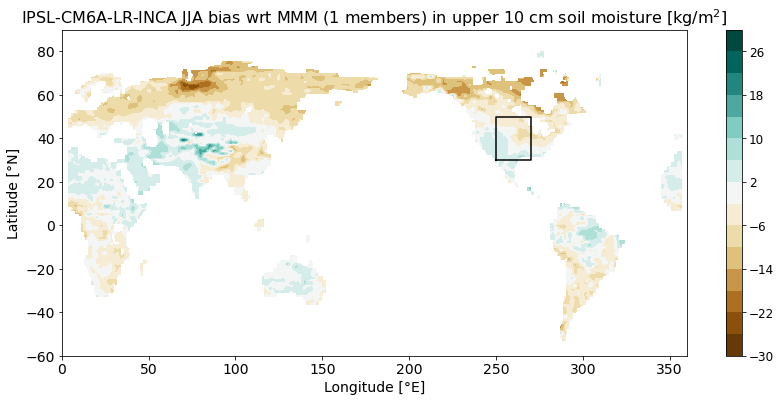

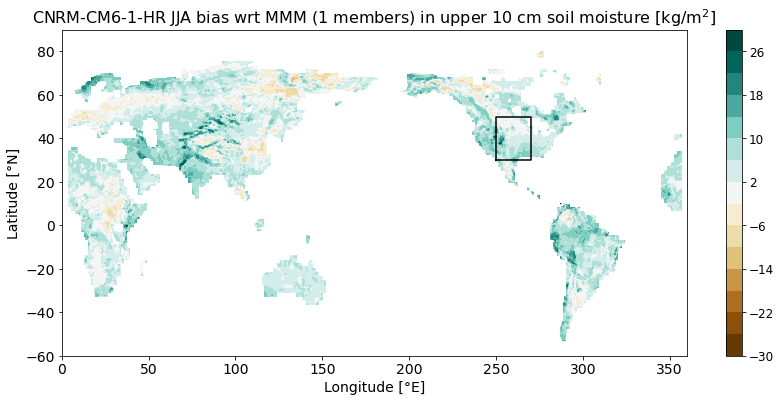

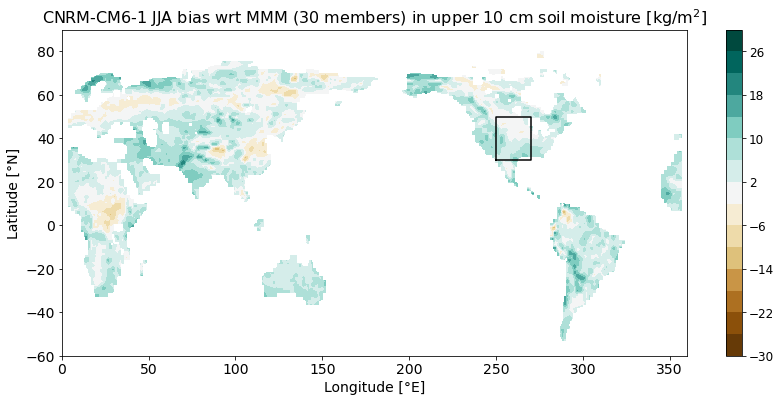

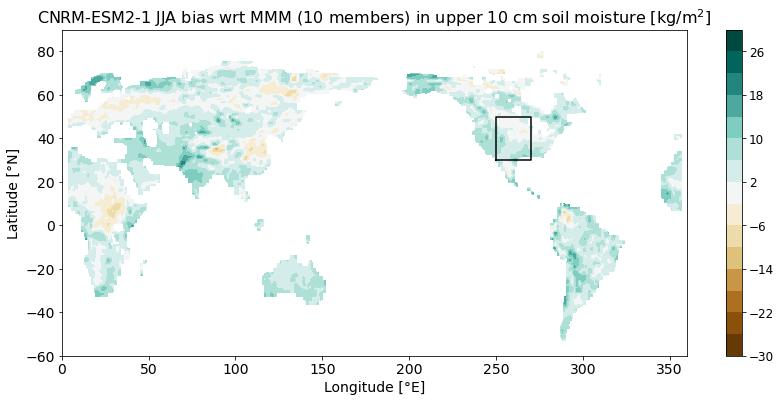

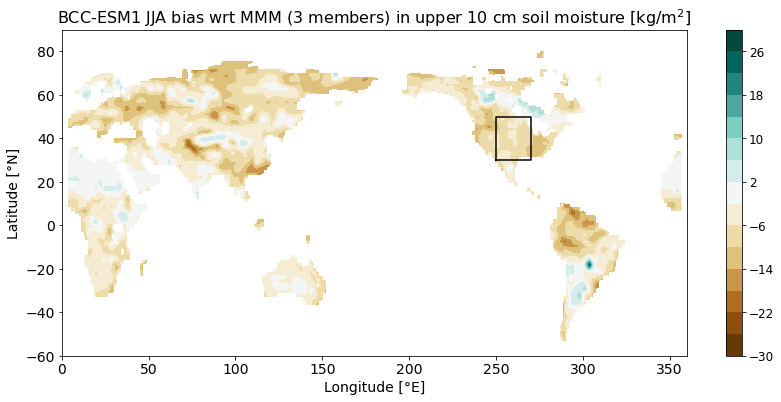

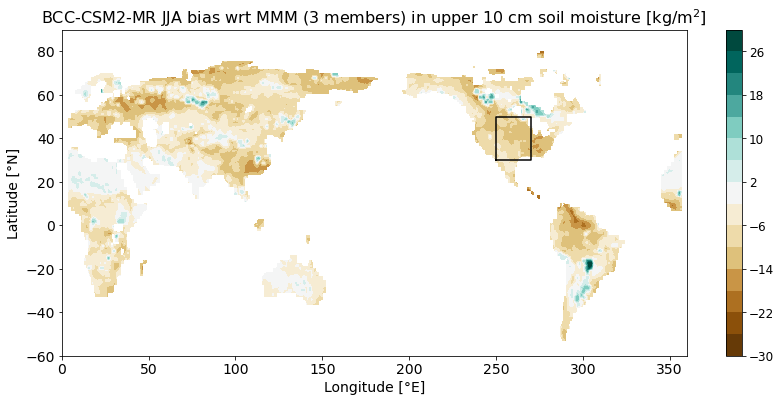

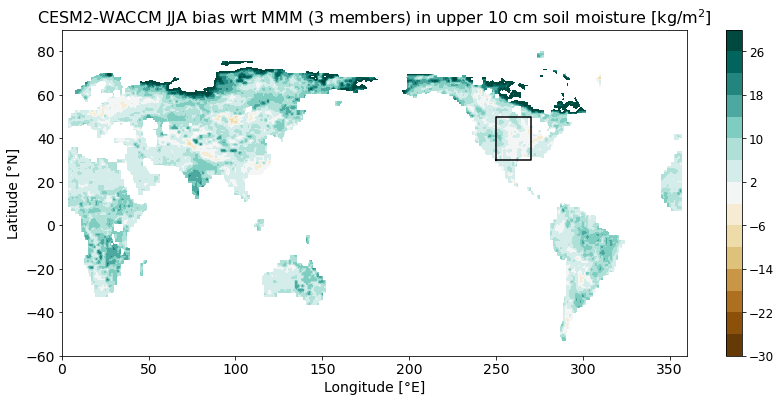

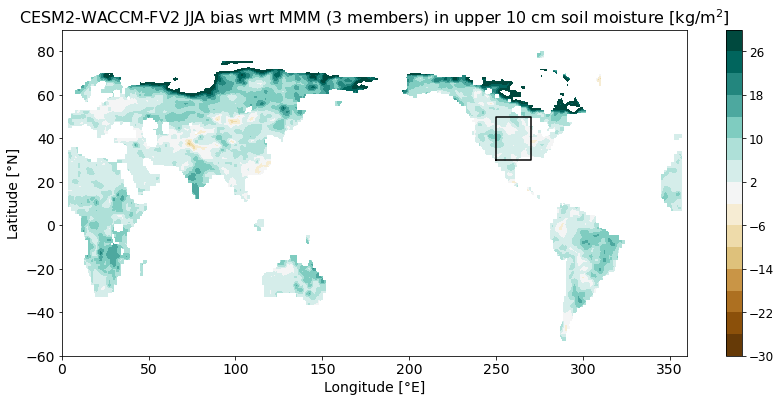

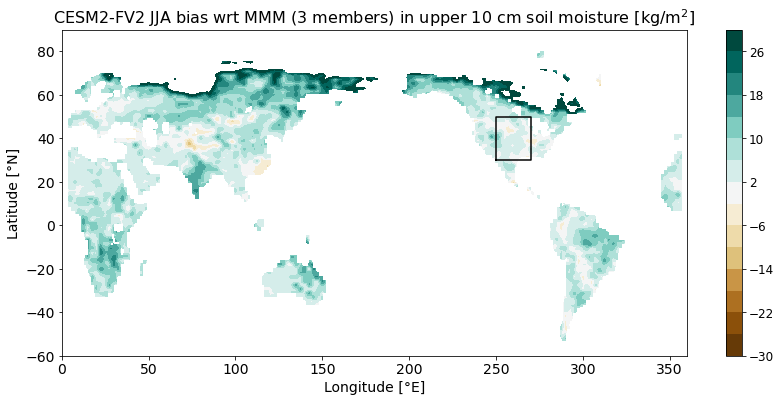

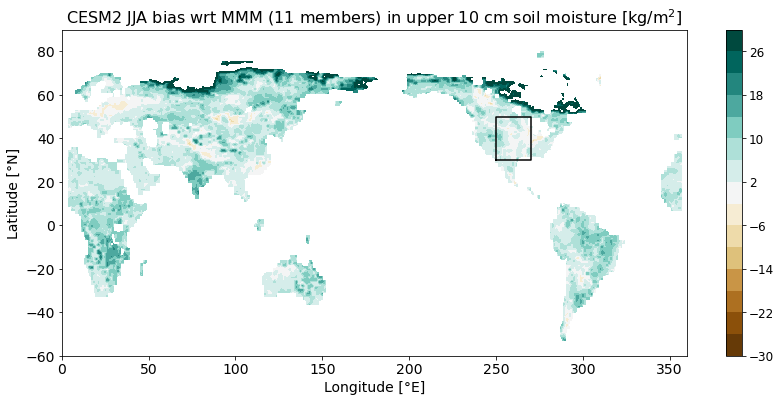

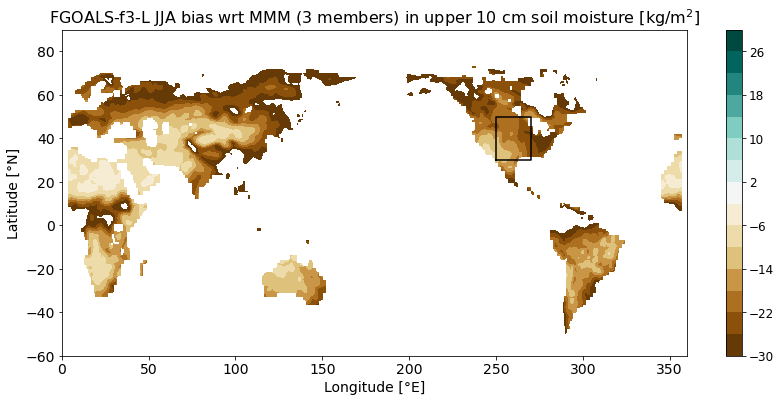

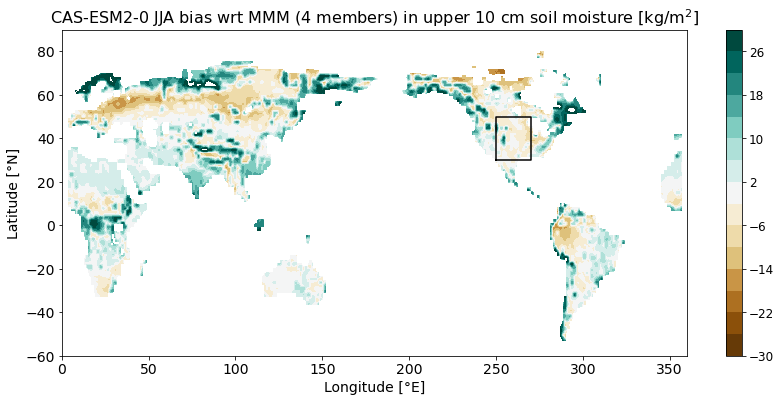

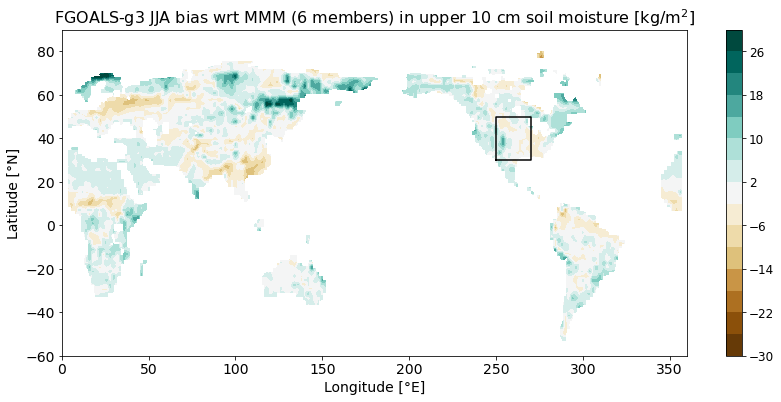

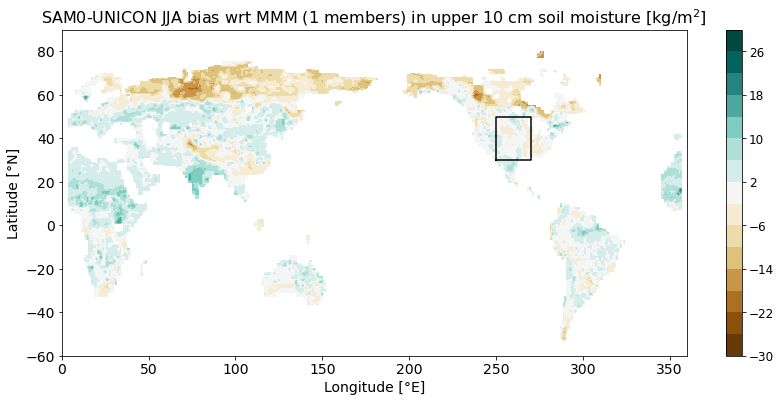

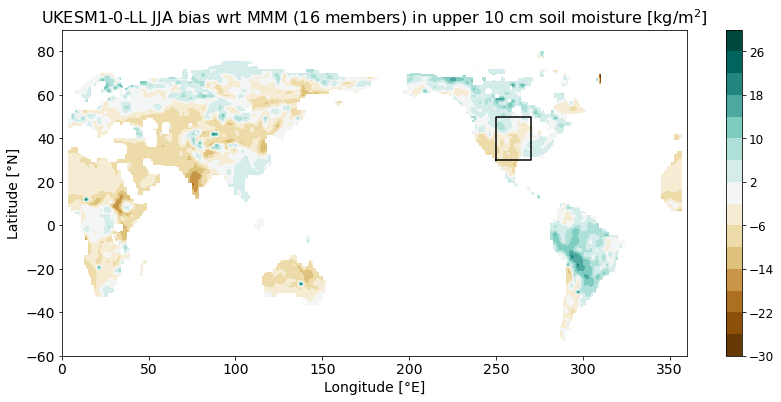

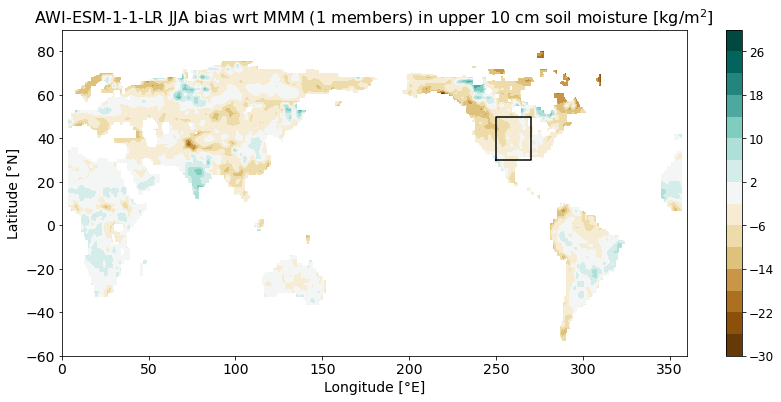

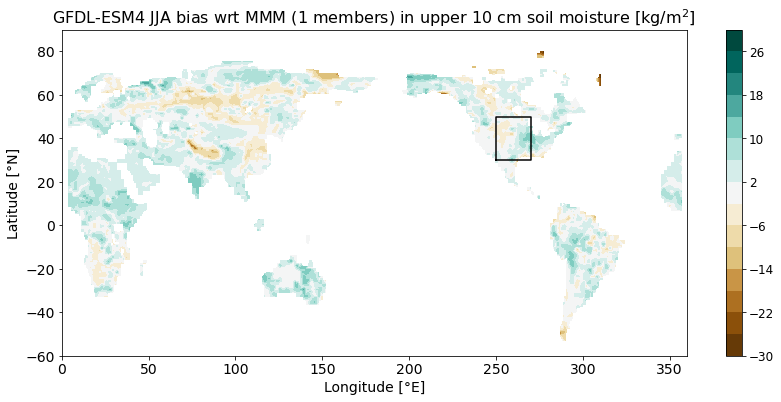

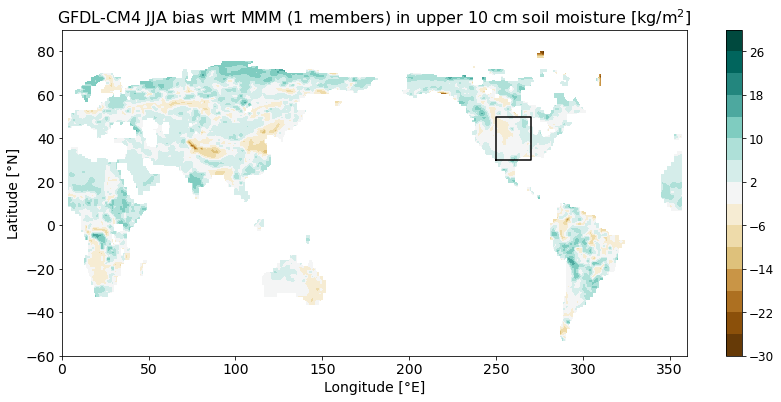

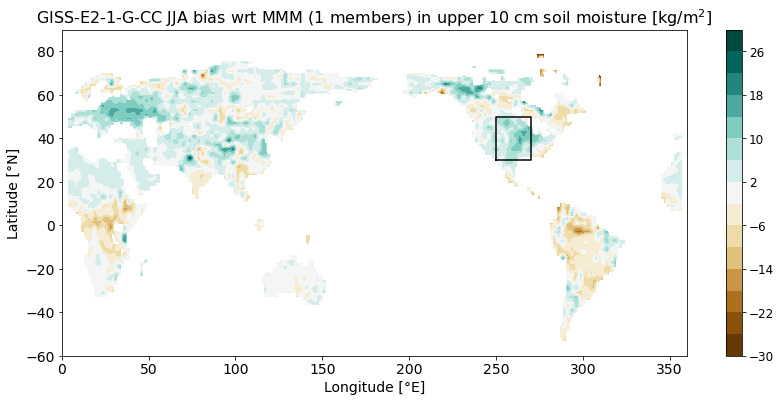

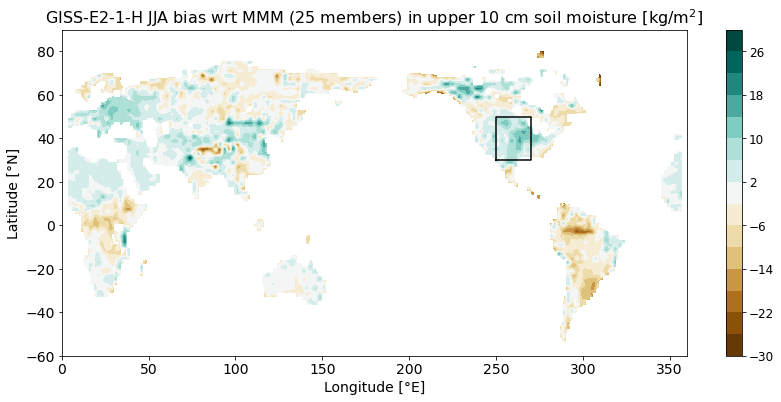

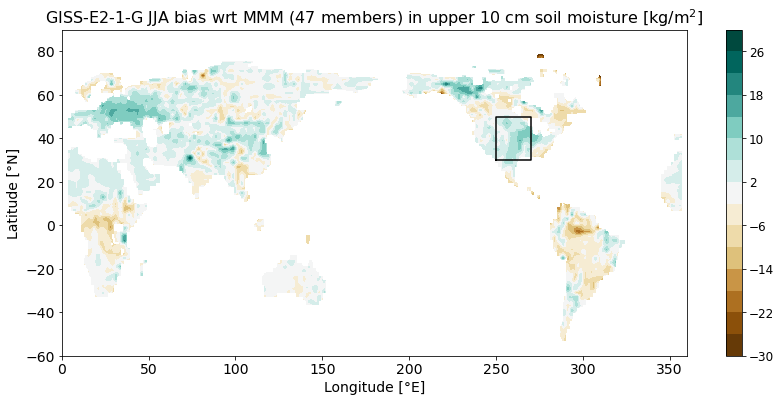

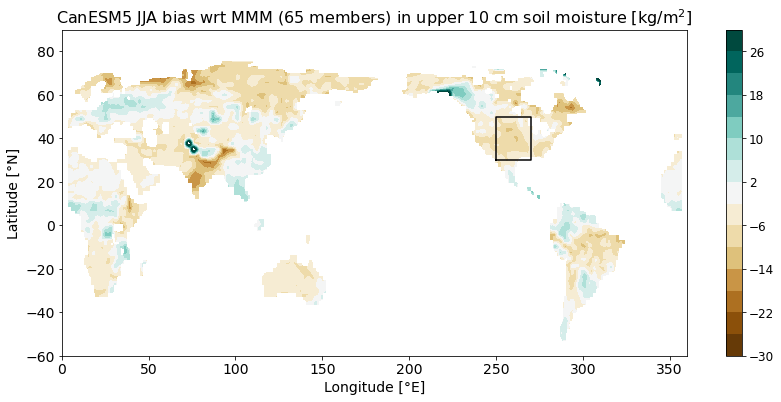

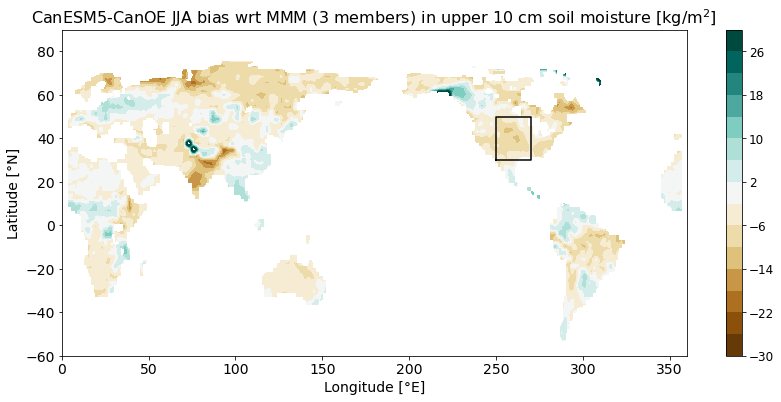

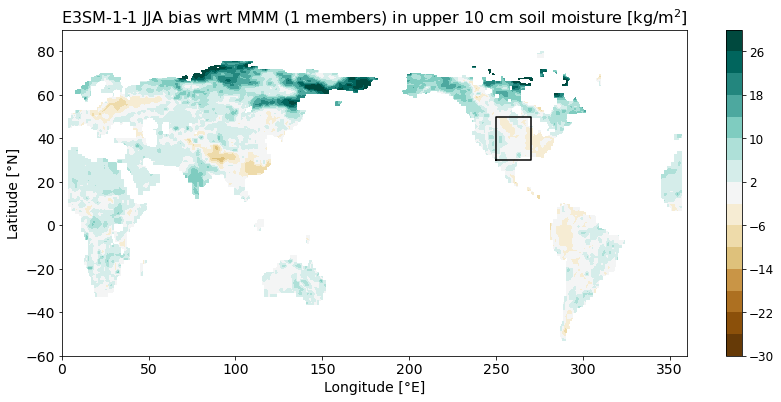

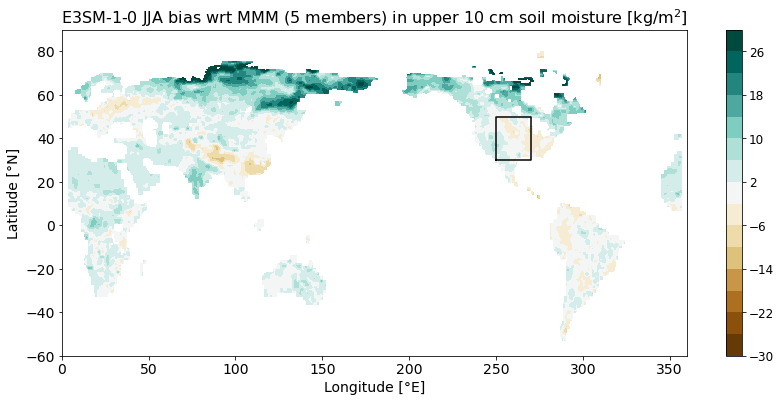

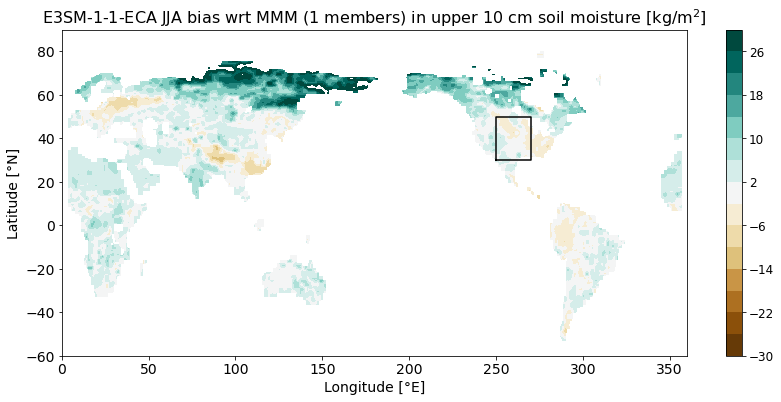

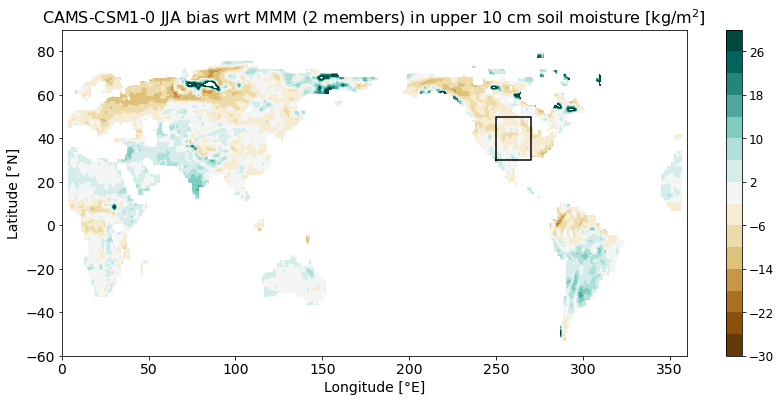

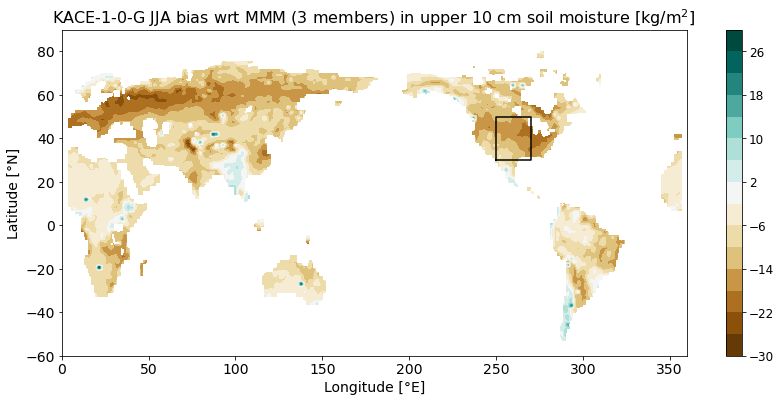

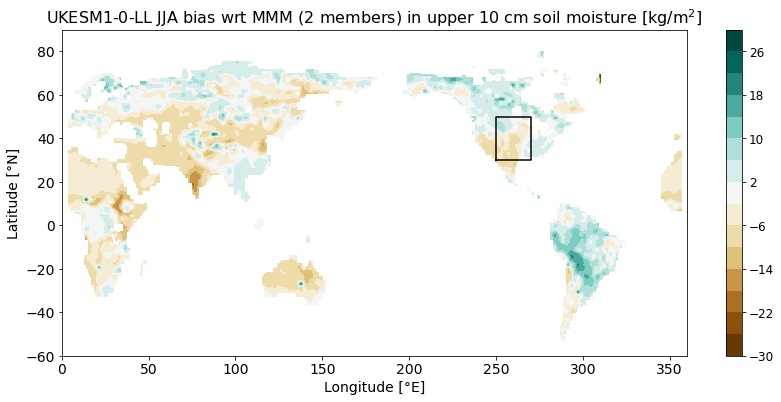

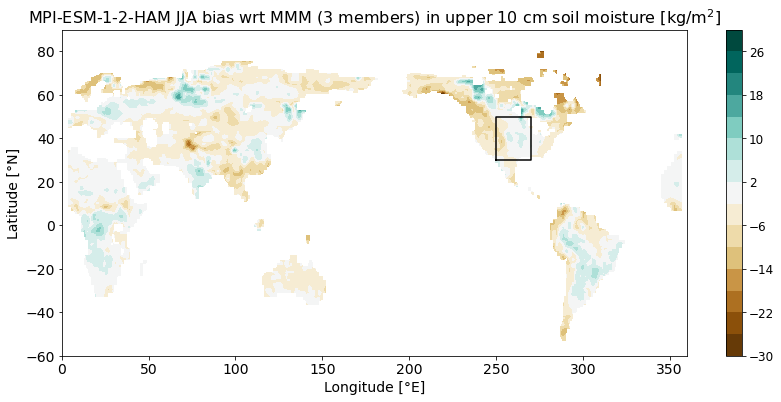

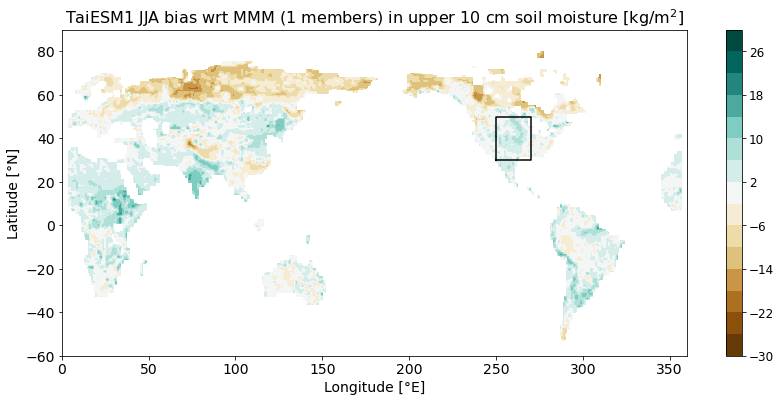

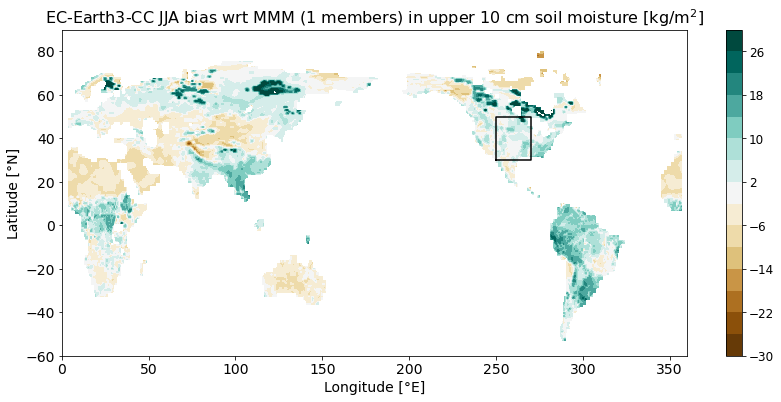

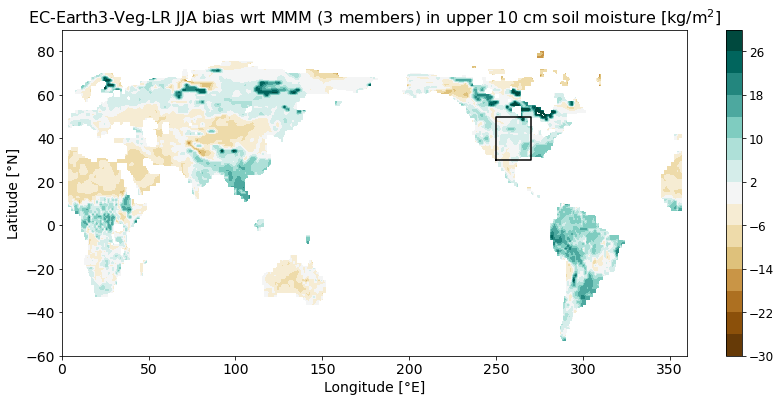

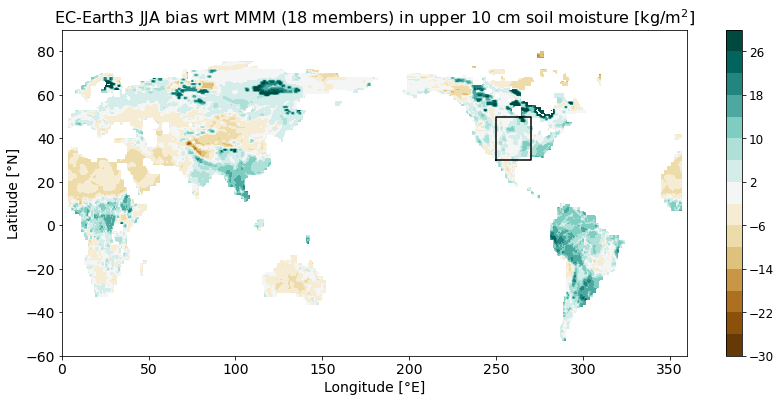

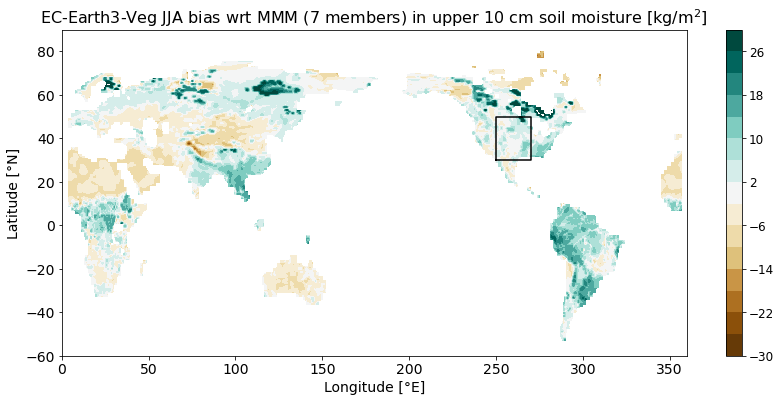

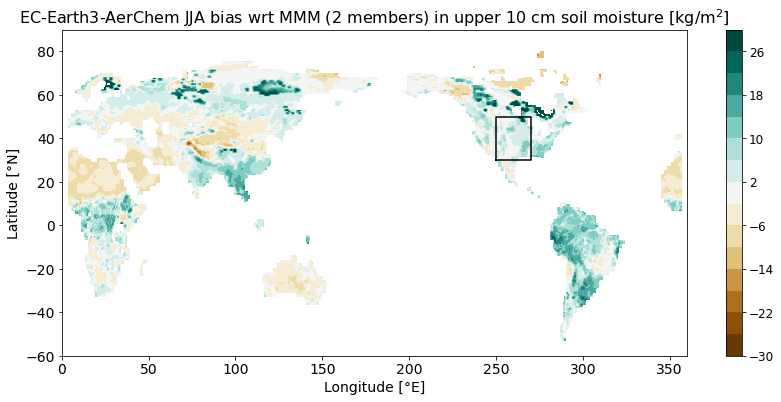

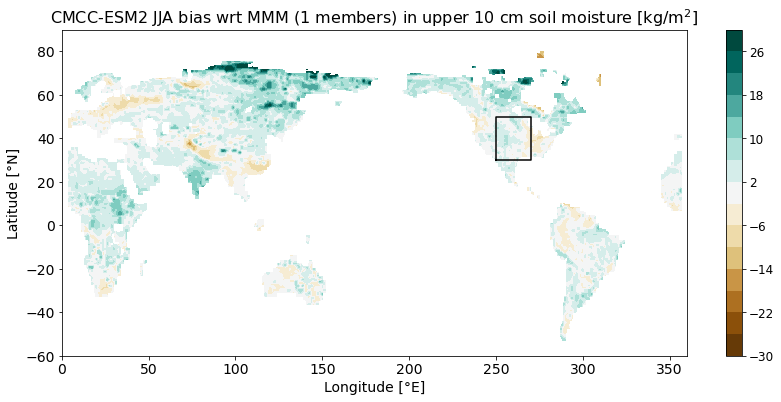

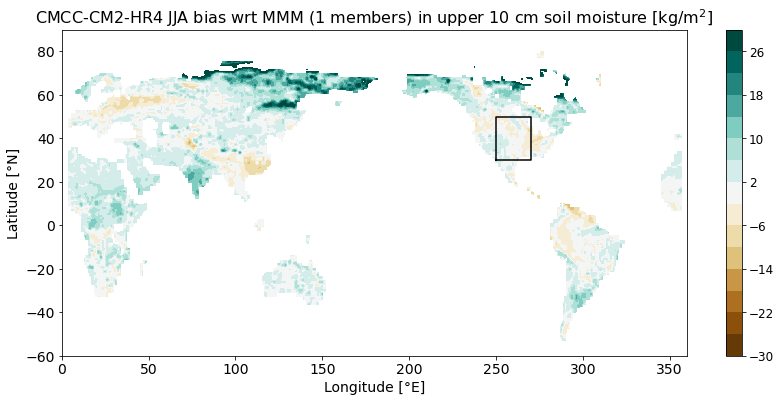

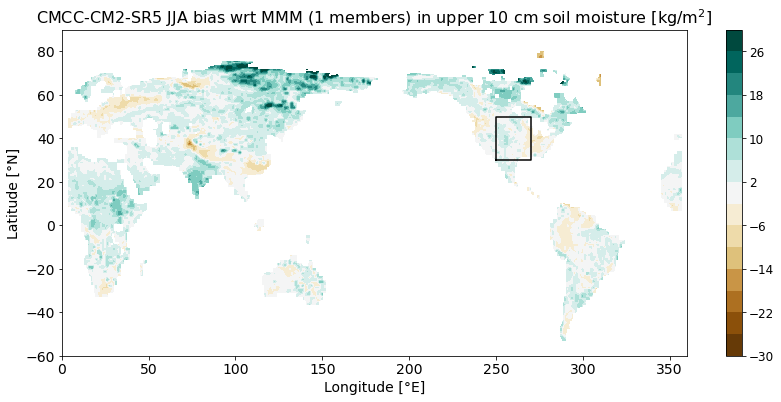

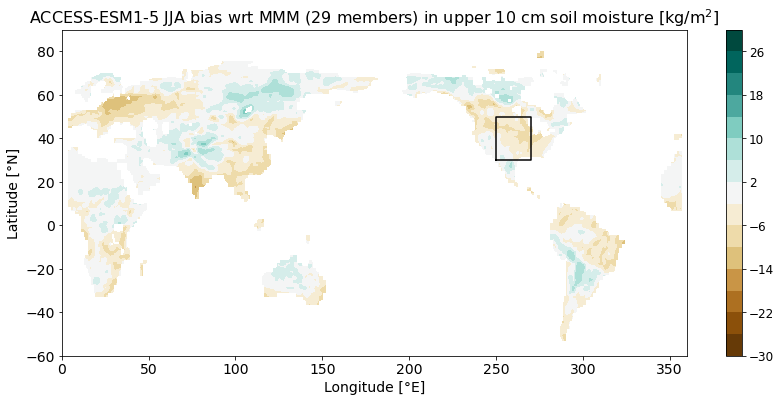

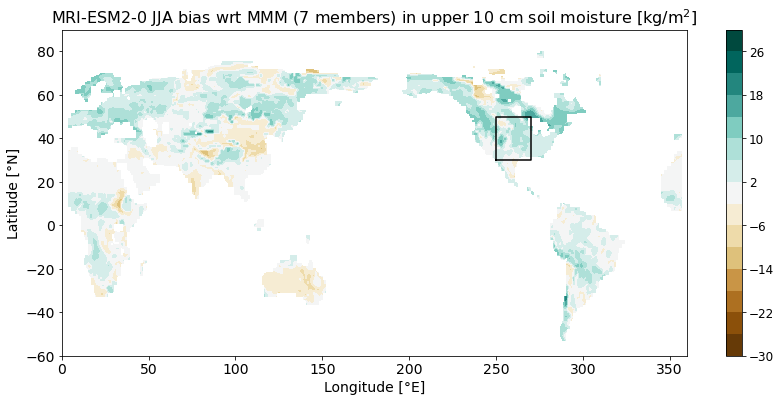

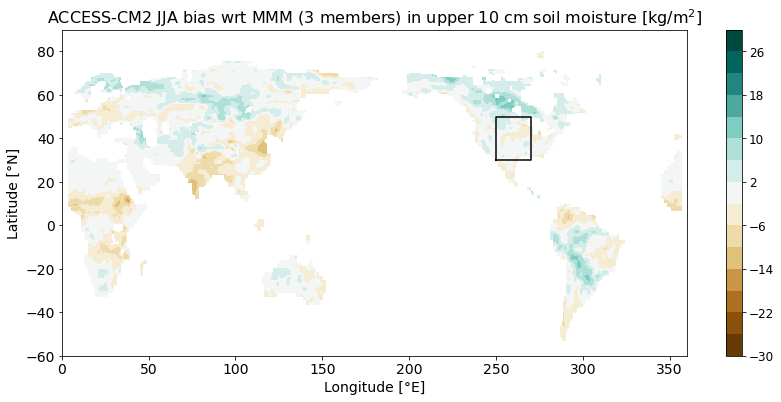

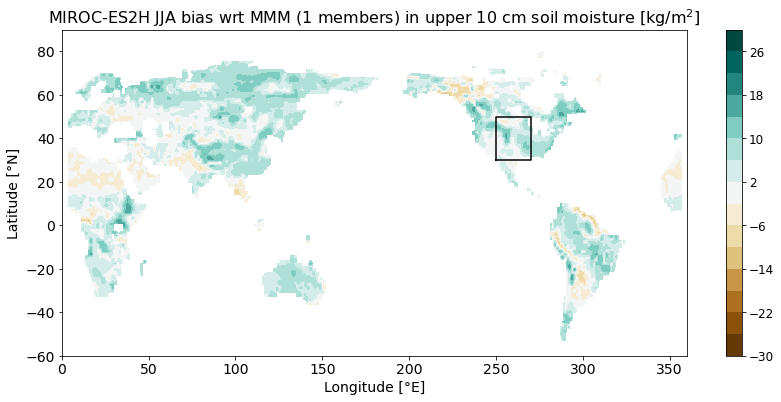

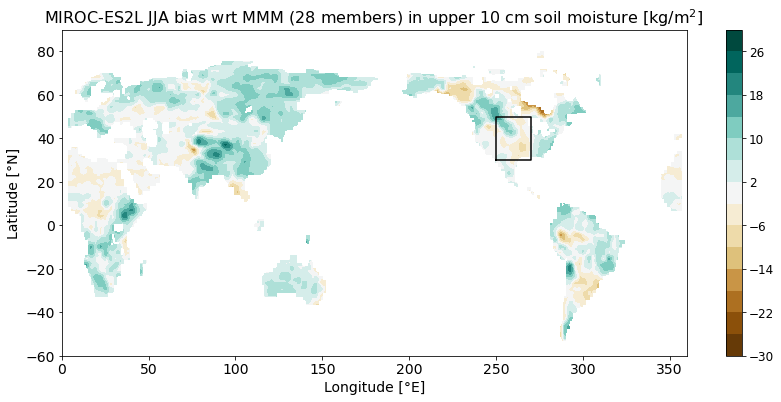

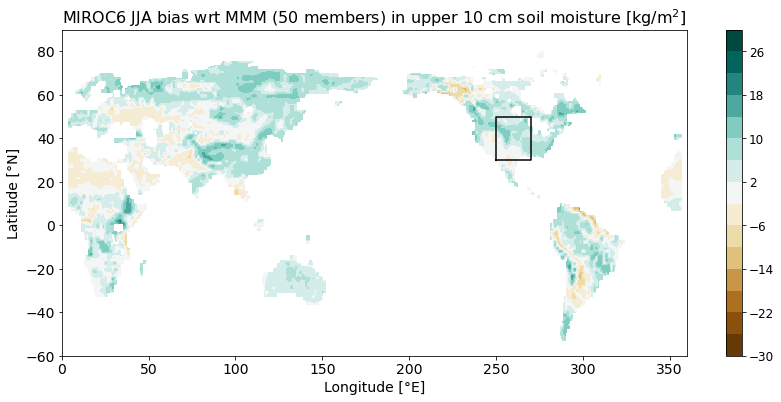

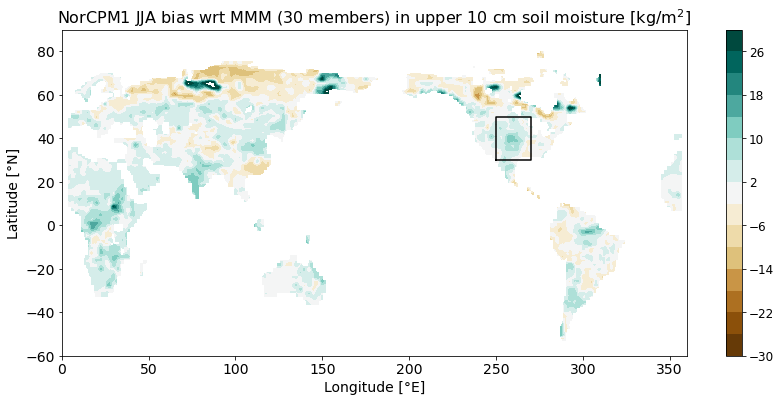

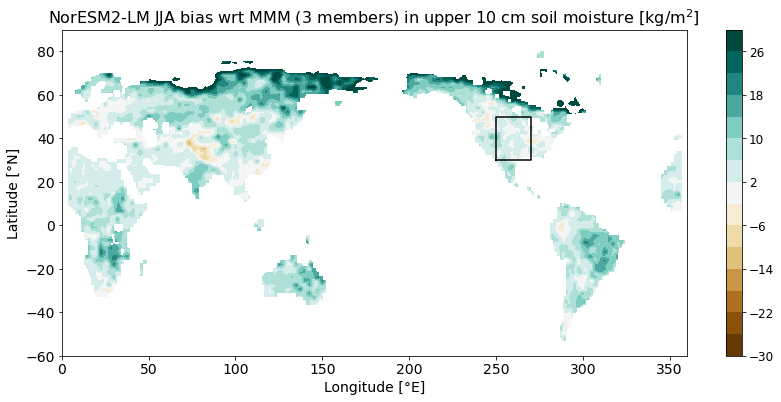

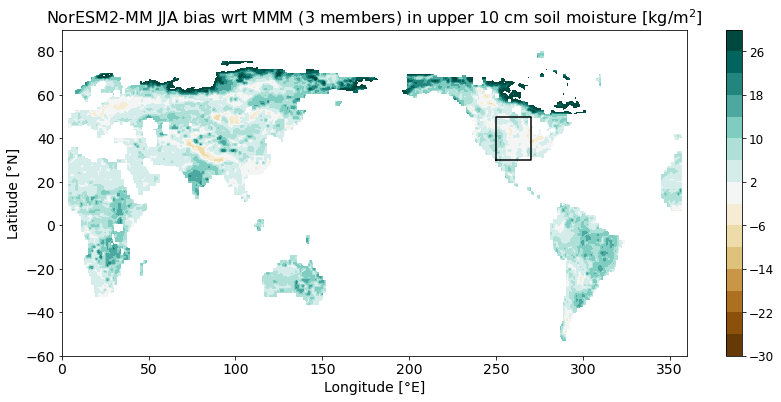

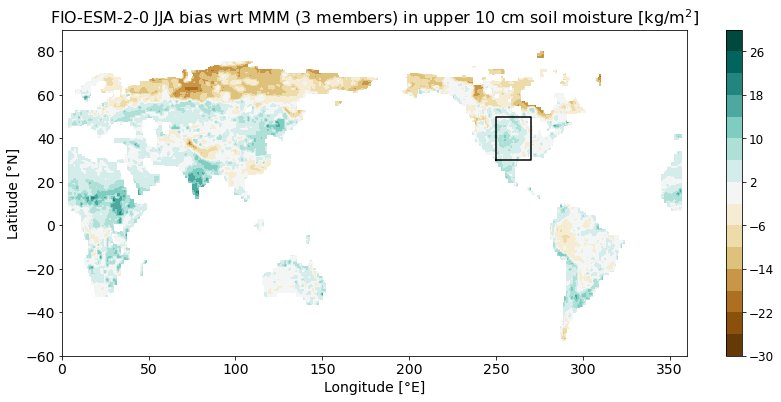

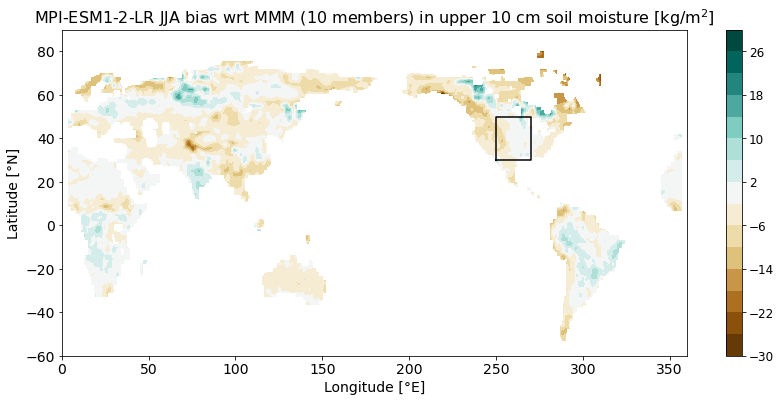

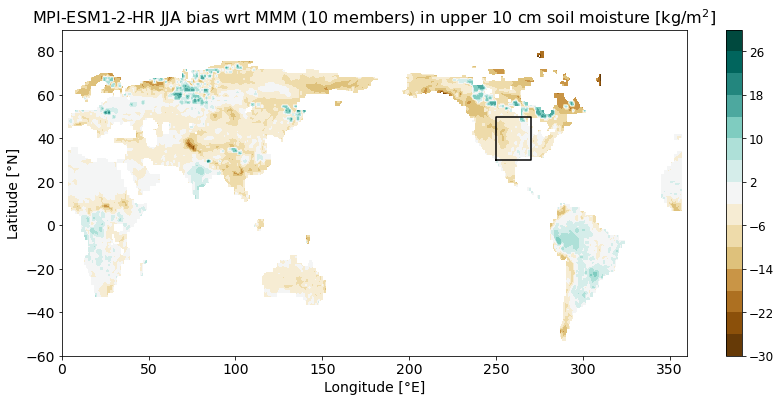

In [50]:
# Compute for each model the anomaly with respect to the MMM, for the specified season.
# Define an area of interest over the north-western CONUS (as in Teng et al., 2019) and stratify the model with respect to the boreal summer MMbias in this region.
# The area selected is {110-90 W; 30-50N}, as in Fig 1f of Teng et al. 2019.

counter = 0
overall_member_counter = 0

extent = [360-110, 360-90, 30, 50] # minlon, maxlon, minlat, maxlat

local_anomaly = np.array([]) # This stores the spatial mean of the MMbias in the area selected by 'extent', for all the models considered.
effective_models = []
effective_members = []

list_of_folders = os.listdir(path2cmip6)
for folder in list_of_folders:
    list_of_models = os.listdir(path2cmip6 + folder)
    for model in list_of_models: 
        list_of_runs = os.listdir(path2cmip6 + folder + '/' + model) # 'historical', 'amip', 'piControl', 'abrupt-4xCO2', etc.
        if 'historical' in list_of_runs: #  Print the name of the models which have the historical run.
            print('# ',model)
            first_field = 1 # We want to average all the ensemble members of a given model.
            path2members = path2cmip6 + folder + '/' + model +'/historical/'
            list_of_members_etal = os.listdir(path2members)
            # Select only the ensemble members and skip the '.paths.txt' entries.
            list_of_members = [idx for idx in list_of_members_etal if idx[0].lower() == 'r'.lower()]
            print('Number of members available: '+str(len(list_of_members)))
            member_counter = 0
            for member in list_of_members: # Print the ensemble members that have info on the mrsos.
                if os.path.exists(path2members + member + '/Lmon/mrsos/gr/latest/'):
                    path2files = path2members + member + '/Lmon/mrsos/gr/latest/'
                elif os.path.exists(path2members + member + '/Lmon/mrsos/gr1/latest/'):
                    path2files = path2members + member + '/Lmon/mrsos/gr1/latest/'
                elif os.path.exists(path2members + member + '/Lmon/mrsos/gn/latest/'):
                    path2files = path2members + member + '/Lmon/mrsos/gn/latest/'
                else:
                    path2files = ''
                    
                if path2files: # If some data are available the path2file is not empty.
                    # Open and concatenate all the files whose final date is after 197901.
                    list_of_files = sorted(os.listdir(path2files))
                    # print('list_of_files =', list_of_files) # There is a member in EC-Earth that has no file but it read anyhow...
                    if list_of_files: # Check whether there are output files to be read.
                        first_file = 1
                        for ll in range(len(list_of_files)):
                            filename = list_of_files[ll]
                            final_date = filename[-9:-3]
                            if int(final_date)>197901: # Here the instant_start is re-written in the form of YYYYMM.
                                da = xr.open_dataset(path2files + filename)
                                if first_file:
                                    db = da
                                    first_file = 0
                                else:
                                    db = xr.concat([db,da],dim='time')
                        
                        # Select the time window according to the type of time axis.
                        if db.time.dtype=='datetime64[ns]':
                            instant_start = np.datetime64('1979-01-01')
                            instant_end = np.datetime64('2014-12-31')
                        else:
                            if db.time.values[0].calendar=='noleap':
                                instant_start = cftime.DatetimeNoLeap(1979,1,1,0,0,0,0,has_year_zero=True)
                                instant_end = cftime.DatetimeNoLeap(2014,12,31,0,0,0,0,has_year_zero=True)
                            elif db.time.values[0].calendar=='360_day':
                                instant_start = cftime.Datetime360Day(1979,1,1,0,0,0,0,has_year_zero=False)
                                instant_end = cftime.Datetime360Day(2014,12,17,0,0,0,0,has_year_zero=False)     

                        # Compute the seasonal MMbias in the time frame of interest and interpolate it on the ERA5 grid.
                        d_time = db.mrsos.sel(time=slice(instant_start,instant_end)) # Select the time window.
                        d_season = d_time.groupby('time.season').mean('time').sel(season=label_season) # Select the season.
                        d_season_i = d_season.interp(lon=ds_era5.longitude,lat=ds_era5.latitude) # Interpolate.
                        
                        if first_field:
                            d_mean4bias = d_season_i-mean_season_mrsos
                            first_field=0
                        else:
                            d_mean4bias += d_season_i-mean_season_mrsos
                        counter += 1
                        member_counter += 1 # This is set to zero for each model.                     
            
            if member_counter>0: # Plot the figure if there is at least one member with a valid field.
                
                # Compute the local anomaly in the area of interest.
                anom = d_mean4bias.sel(longitude=slice(extent[0],extent[1]),latitude=slice(extent[3],extent[2])).mean('longitude',skipna=True).mean('latitude',skipna=True)
                local_anomaly = np.append(local_anomaly,anom/member_counter)

                effective_models.append(model)
                effective_members.append(member_counter)

                print(local_anomaly)
                print(effective_models)
                print(effective_members)
          
                # Plot the map of the bias for a given model.
                mmbias_season_mrsos = d_mean4bias.values/member_counter

                fig = plt.figure(figsize=(14,6))
                pc = plt.contourf(lon,lat,mmbias_season_mrsos,levels=np.arange(-30,34,4),cmap='BrBG')
                plt.plot([extent[0],extent[1],extent[1],extent[0],extent[0]],[extent[2],extent[2],extent[3],extent[3],extent[2]],'k')
                plt.xlabel('Longitude [°E]',fontsize=14)
                plt.ylabel('Latitude [°N]',fontsize=14)
                plt.ylim([-60,90])
                plt.tick_params(axis='both',labelsize=14)

                cb = plt.colorbar(pc)
                cb.ax.tick_params(labelsize=12)

                plt.title(model+ ' '+ label_season +' bias wrt MMM ('+str(member_counter)+' members) in upper 10 cm soil moisture [kg/m$^2$]',fontsize=16)
                plt.savefig('mmbias_'+ label_season + '_' + model + '_mrsos_1979-2014.png',bbox_inches='tight')

            overall_member_counter += member_counter
                                        
    print('----------')
    
print('Number of members actually used in total: '+ str(counter))

In [55]:
# Save as a txt file the variables local_anomaly, effective_models and effective_members.

import pandas as pd

dict = {'local_anomaly_kg_m-2': list(local_anomaly), 'effective_models': effective_models, 'effective_members': effective_members}  
df = pd.DataFrame(dict)
     
# saving the dataframe
df.to_csv(label_season+'_local_anomaly_mrsos.csv')

df

local_anomaly_kg_m-2   effective_models  effective_members
0              -1.829249       IPSL-CM6A-LR                 33
1             -12.237644    IPSL-CM5A2-INCA                  1
2              -1.196175  IPSL-CM6A-LR-INCA                  1
3               3.996574      CNRM-CM6-1-HR                  1
4               3.269051         CNRM-CM6-1                 30
5               3.028370        CNRM-ESM2-1                 10
6              -7.162547           BCC-ESM1                  3
7              -9.809502        BCC-CSM2-MR                  3
8               2.115739        CESM2-WACCM                  3
9               3.098762    CESM2-WACCM-FV2                  3
10              2.258030          CESM2-FV2                  3
11              2.322544              CESM2                 11
12            -19.387161        FGOALS-f3-L                  3
13             -2.536089         CAS-ESM2-0                  4
14              0.330565          FGOALS-g3                  6
15             -0.568153        SAM0-UNICON                  1
16             -2.579802        UKESM1-0-LL                 16
17             -4.172085     AWI-ESM-1-1-LR                  1
18              0.835081          GFDL-ESM4                  1
19              0.175573           GFDL-CM4                  1
20              5.918163     GISS-E2-1-G-CC                  1
21              5.936391        GISS-E2-1-H                 25
22              4.586448        GISS-E2-1-G                 47
23             -6.517100            CanESM5                 65
24             -6.692663      CanESM5-CanOE                  3
25             -0.381960           E3SM-1-1                  1
26             -0.658323           E3SM-1-0                  5
27             -0.631455       E3SM-1-1-ECA                  1
28             -3.248505        CAMS-CSM1-0                  2
29            -14.173259         KACE-1-0-G                  3
30             -2.659000        UKESM1-0-LL                  2
31             -1.353820    MPI-ESM-1-2-HAM                  3
32              2.174511            TaiESM1                  1
33              2.063817       EC-Earth3-CC                  1
34              2.066414   EC-Earth3-Veg-LR                  3
35              2.339338          EC-Earth3                 18
36              1.920256      EC-Earth3-Veg                  7
37              2.618671  EC-Earth3-AerChem                  2
38              0.834174          CMCC-ESM2                  1
39             -0.782296       CMCC-CM2-HR4                  1
40              0.446254       CMCC-CM2-SR5                  1
41             -4.218872      ACCESS-ESM1-5                 29
42              3.804012         MRI-ESM2-0                  7
43             -0.707391         ACCESS-CM2                  3
44              3.263186         MIROC-ES2H                  1
45             -0.344961         MIROC-ES2L                 28
46              3.664224             MIROC6                 50
47              2.773977            NorCPM1                 30
48              2.478701         NorESM2-LM                  3
49              1.945156         NorESM2-MM                  3
50              2.592588        FIO-ESM-2-0                  3
51             -2.269404      MPI-ESM1-2-LR                 10
52             -4.004516      MPI-ESM1-2-HR                 10

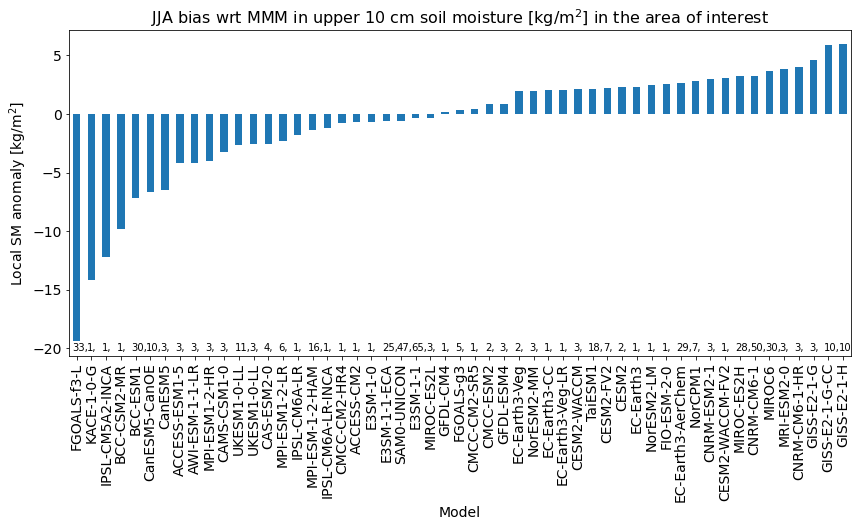

In [89]:
df_sorted = df.sort_values('local_anomaly_kg_m-2')

df_sorted.plot.bar(x='effective_models',y='local_anomaly_kg_m-2',figsize=(14,6),fontsize=14,legend=False)
plt.xlabel('Model',fontsize=14)
plt.ylabel('Local SM anomaly [kg/m$^2$]',fontsize=14)

s = df_sorted.effective_members
for kk in range(len(s)-1):
    plt.text(kk-0.3,-20.2,str(s[kk])+',')
plt.text(kk+1-0.3,-20.2,str(s[kk+1]))

plt.title(label_season +' bias wrt MMM in upper 10 cm soil moisture [kg/m$^2$] in the area of interest',fontsize=16)
plt.savefig('model_stratification_'+ label_season + '_mrsos_1979-2014_local_anomaly.png',bbox_inches='tight')